In [1]:
import warnings

from iterdub import iterdub as ib
from iterpop import iterpop as ip
from keyname import keyname as kn
from matplotlib import pyplot as plt
import matplotlib
from nbmetalog import nbmetalog as nbm
import numpy as np
import pandas as pd
import pathlib
from scipy import stats
import seaborn as sns
from slugify import slugify
import statsmodels.api as sm
import statsmodels.formula.api as smf
from teeplot import teeplot as tp


In [2]:
from conduitpylib.utils import (
    consolidate_merge,
    count_outliers,
    count_nonoutliers,
    count_proportion_outliers,
)

from conduitpylib.wrangle import (
    find_treat_idx_mapped_col,
    retrieve_and_prepare_delta_dataframes,
    wrangle_world_sums,
)


<Figure size 72x72 with 0 Axes>

In [3]:
nbm.print_metadata()


context: ci
hostname: c21e637b41f4
interpreter: 3.8.10 (default, May 26 2023, 14:05:08)  [GCC 9.4.0]
nbcellexec: 3
nbname: a=with-lac-417-vs-sans-lac-417+compute-work=0+simels_per_cpu=2048+ext=
nbpath: /opt/conduit/binder/date=2021+project=72k5n/a=with-lac-417-vs-sans-lac-417/a=with-lac-417-vs-sans-lac-417+compute-work=0+simels_per_cpu=2048+ext=.ipynb
revision: null
session: eb70ba67-97f4-4c09-ad0f-d7c5dc70dd1b
timestamp: 2023-11-19T00:02:34Z00:00


IPython==7.16.1
keyname==0.5.3
yaml==5.4.1
iterdub==0.2.0
iterpop==0.3.4
matplotlib==3.5.2
nbmetalog==0.2.6
numpy==1.23.5
pandas==1.1.2
scipy==1.5.4
seaborn==0.13.0
statsmodels==0.12.2
teeplot==0.6.1
re==2.2.1
ipython_genutils==0.2.0
logging==0.5.1.2
zmq==22.2.1
json==2.0.9
six==1.15.0
ipykernel==5.5.3


# Get Data


In [4]:
merge_df, (
    df_finalized_observations,
    df_snapshot_diffs,
) = retrieve_and_prepare_delta_dataframes(
    df_inlet_url="https://osf.io/jgpnv/download",
    df_outlet_url="https://osf.io/ncdfq/download",
    treatment_column="Allocation",
    return_merge_df=True,
)

allocation_idx_mapped_title = find_treat_idx_mapped_col(df_snapshot_diffs)
allocation_idx_mapped_title


a: df_inlet
digest: f5e773e930982d7a2fa6fe51fcbaaee0d1b08a120f140662bc07d0d537da37d3
num cols: 45
num cols all na: 2
num cols any na: 2
num na: 133120
num rows: 66560
num rows all na: 0
num rows any na: 66560
size: 62M

a: df_outlet
digest: ce7c97600d27e972d19d35c0e30021716f4f553dab5763d3c29bf5010f75b8cb
num cols: 71
num cols all na: 6
num cols any na: 6
num na: 399360
num rows: 66560
num rows all na: 0
num rows any na: 66560
size: 75M



'0 = Sans lac-417 | 1 = With lac-417'

In [5]:
df_world_sum = wrangle_world_sums(df_finalized_observations)


# End-state Data Analysis

This data appears to be skewed by ragged network launch/completion.


In [6]:
from conduitpylib.viz import facet_boxplot


## Latency Walltime


teeplots/latency-walltime-inlet-s/row=num-simels-per-cpu+transform=endstate_sumedbyrep+viz=facet-boxplot+x=0-sans-lac-417-1-with-lac-417+y=latency-walltime-inlet-s+ext=.pdf
skipping teeplots/latency-walltime-inlet-s/row=num-simels-per-cpu+transform=endstate_sumedbyrep+viz=facet-boxplot+x=0-sans-lac-417-1-with-lac-417+y=latency-walltime-inlet-s+ext=.png


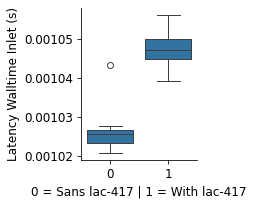

In [7]:
tp.tee(
    facet_boxplot,
    data=df_world_sum,
    row='Num Simels Per Cpu',
    x=allocation_idx_mapped_title,
    y='Latency Walltime Inlet (s)',
    showfliers=True,
    teeplot_outattrs={
        **{
            'transform' : 'endstate_sumedbyrep',
        },
        **nbm.collate_outattr_metadata(),
    },
    teeplot_subdir='latency-walltime-inlet-s',
)


teeplots/latency-walltime-outlet-s/row=num-simels-per-cpu+transform=endstate_sumedbyrep+viz=facet-boxplot+x=0-sans-lac-417-1-with-lac-417+y=latency-walltime-outlet-s+ext=.pdf
skipping teeplots/latency-walltime-outlet-s/row=num-simels-per-cpu+transform=endstate_sumedbyrep+viz=facet-boxplot+x=0-sans-lac-417-1-with-lac-417+y=latency-walltime-outlet-s+ext=.png


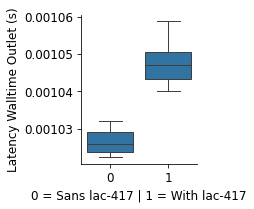

In [8]:
tp.tee(
    facet_boxplot,
    data=df_world_sum,
    row='Num Simels Per Cpu',
    x=allocation_idx_mapped_title,
    y='Latency Walltime Outlet (s)',
    showfliers=True,
    teeplot_outattrs={
        **{
            'transform' : 'endstate_sumedbyrep',
        },
        **nbm.collate_outattr_metadata(),
    },
    teeplot_subdir='latency-walltime-outlet-s',
)


## Latency Simsteps


teeplots/latency-simsteps-inlet/row=num-simels-per-cpu+transform=endstate_sumedbyrep+viz=facet-boxplot+x=0-sans-lac-417-1-with-lac-417+y=latency-simsteps-inlet+ext=.pdf
skipping teeplots/latency-simsteps-inlet/row=num-simels-per-cpu+transform=endstate_sumedbyrep+viz=facet-boxplot+x=0-sans-lac-417-1-with-lac-417+y=latency-simsteps-inlet+ext=.png


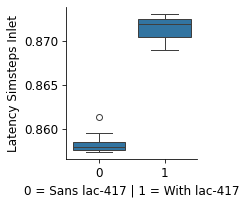

In [9]:
tp.tee(
    facet_boxplot,
    data=df_world_sum,
    row='Num Simels Per Cpu',
    x=allocation_idx_mapped_title,
    y='Latency Simsteps Inlet',
    showfliers=True,
    teeplot_outattrs={
        **{
            'transform' : 'endstate_sumedbyrep',
        },
        **nbm.collate_outattr_metadata(),
    },
    teeplot_subdir='latency-simsteps-inlet',
)


teeplots/latency-simsteps-outlet/row=num-simels-per-cpu+transform=endstate_sumedbyrep+viz=facet-boxplot+x=0-sans-lac-417-1-with-lac-417+y=latency-simsteps-outlet+ext=.pdf
skipping teeplots/latency-simsteps-outlet/row=num-simels-per-cpu+transform=endstate_sumedbyrep+viz=facet-boxplot+x=0-sans-lac-417-1-with-lac-417+y=latency-simsteps-outlet+ext=.png


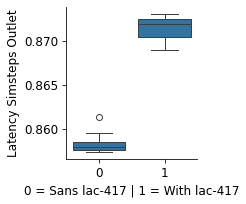

In [10]:
tp.tee(
    facet_boxplot,
    data=df_world_sum,
    row='Num Simels Per Cpu',
    x=allocation_idx_mapped_title,
    y='Latency Simsteps Outlet',
    showfliers=True,
    teeplot_outattrs={
        **{
            'transform' : 'endstate_sumedbyrep',
        },
        **nbm.collate_outattr_metadata(),
    },
    teeplot_subdir='latency-simsteps-outlet',
)


## Delivery Failure Rate


teeplots/delivery-failure-rate/row=num-simels-per-cpu+transform=endstate_sumedbyrep+viz=facet-boxplot+x=0-sans-lac-417-1-with-lac-417+y=delivery-failure-rate+ext=.pdf
skipping teeplots/delivery-failure-rate/row=num-simels-per-cpu+transform=endstate_sumedbyrep+viz=facet-boxplot+x=0-sans-lac-417-1-with-lac-417+y=delivery-failure-rate+ext=.png


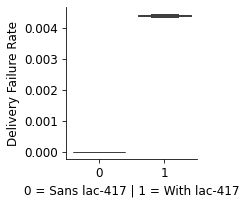

In [11]:
tp.tee(
    facet_boxplot,
    data=df_world_sum,

    row='Num Simels Per Cpu',
    x=allocation_idx_mapped_title,
    y='Delivery Failure Rate',
    showfliers=True,
    teeplot_outattrs={
        **{
            'transform' : 'endstate_sumedbyrep',
        },
        **nbm.collate_outattr_metadata(),
    },
    teeplot_subdir='delivery-failure-rate',
)


## Delivery Clumpiness


teeplots/delivery-clumpiness/row=num-simels-per-cpu+transform=endstate_sumedbyrep+viz=facet-boxplot+x=0-sans-lac-417-1-with-lac-417+y=delivery-clumpiness+ext=.pdf
skipping teeplots/delivery-clumpiness/row=num-simels-per-cpu+transform=endstate_sumedbyrep+viz=facet-boxplot+x=0-sans-lac-417-1-with-lac-417+y=delivery-clumpiness+ext=.png


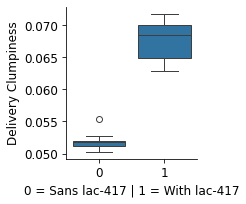

In [12]:
tp.tee(
    facet_boxplot,
    data=df_world_sum,
    row='Num Simels Per Cpu',
    x=allocation_idx_mapped_title,
    y='Delivery Clumpiness',
    showfliers=True,
    teeplot_outattrs={
        **{
            'transform' : 'endstate_sumedbyrep',
        },
        **nbm.collate_outattr_metadata(),
    },
    teeplot_subdir='delivery-clumpiness',
)


## Simstep Period


teeplots/simstep-period-inlet-s/row=num-simels-per-cpu+transform=endstate_sumedbyrep+viz=facet-boxplot+x=0-sans-lac-417-1-with-lac-417+y=simstep-period-inlet-s+ext=.pdf
skipping teeplots/simstep-period-inlet-s/row=num-simels-per-cpu+transform=endstate_sumedbyrep+viz=facet-boxplot+x=0-sans-lac-417-1-with-lac-417+y=simstep-period-inlet-s+ext=.png


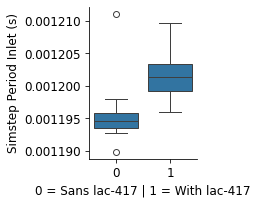

In [13]:
tp.tee(
    facet_boxplot,
    data=df_world_sum,
    row='Num Simels Per Cpu',
    x=allocation_idx_mapped_title,
    y='Simstep Period Inlet (s)',
    showfliers=True,
    teeplot_outattrs={
        **{
            'transform' : 'endstate_sumedbyrep',
        },
        **nbm.collate_outattr_metadata(),
    },
    teeplot_subdir='simstep-period-inlet-s',
)


teeplots/simstep-period-outlet-s/row=num-simels-per-cpu+transform=endstate_sumedbyrep+viz=facet-boxplot+x=0-sans-lac-417-1-with-lac-417+y=simstep-period-outlet-s+ext=.pdf
skipping teeplots/simstep-period-outlet-s/row=num-simels-per-cpu+transform=endstate_sumedbyrep+viz=facet-boxplot+x=0-sans-lac-417-1-with-lac-417+y=simstep-period-outlet-s+ext=.png


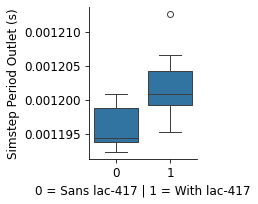

In [14]:
tp.tee(
    facet_boxplot,
    data=df_world_sum,
    row='Num Simels Per Cpu',
    x=allocation_idx_mapped_title,
    y='Simstep Period Outlet (s)',
    showfliers=True,
    teeplot_outattrs={
        **{
            'transform' : 'endstate_sumedbyrep',
        },
        **nbm.collate_outattr_metadata(),
    },
    teeplot_subdir='simstep-period-outlet-s',
)


# Live Snapshot Analysis


In [15]:
from conduitpylib.viz import (
    facet_barplot,
    facet_boxplot_withfliers,
    facet_boxplot_nofliers,
)


## Latency Walltime


teeplots/latency-walltime-inlet-ns/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-barplot+x=0-sans-lac-417-1-with-lac-417+y=latency-walltime-inlet-ns+ext=.pdf
skipping teeplots/latency-walltime-inlet-ns/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-barplot+x=0-sans-lac-417-1-with-lac-417+y=latency-walltime-inlet-ns+ext=.png
teeplots/latency-walltime-inlet-ns/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-withfliers+x=0-sans-lac-417-1-with-lac-417+y=latency-walltime-inlet-ns+ext=.pdf
skipping teeplots/latency-walltime-inlet-ns/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-withfliers+x=0-sans-lac-417-1-with-lac-417+y=latency-walltime-inlet-ns+ext=.png
teeplots/latency-walltime-inlet-ns/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-nofliers+x=0-sans-lac-417-1-with-lac-417+y=latency-walltime-inlet-ns+ext=.pdf
skipping teeplots/latency-walltime-inlet-ns/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet

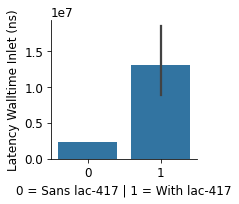

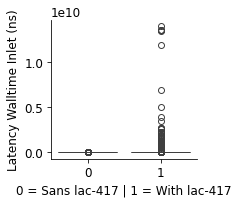

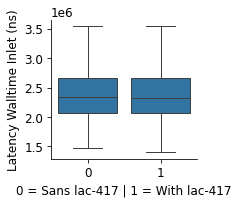

In [16]:
for viz in facet_barplot, facet_boxplot_withfliers, facet_boxplot_nofliers:
    tp.tee(
        viz,
        data=df_snapshot_diffs,
        row='Num Simels Per Cpu',
        x=allocation_idx_mapped_title,
        y='Latency Walltime Inlet (ns)',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs',
            },
            **nbm.collate_outattr_metadata(),
        },
        teeplot_subdir='latency-walltime-inlet-ns',
    )


### Simple Mean and Median


In [17]:
# adapted from https://stackoverflow.com/a/13592901
df_snapshot_diffs.groupby([
    allocation_idx_mapped_title,
]).agg({
    'Latency Walltime Inlet (ns)' : [
        np.mean,
        np.median,
    ],
})


Latency Walltime Inlet (ns)              
                                                           mean        median
0 = Sans lac-417 | 1 = With lac-417                                          
0                                                  2.402726e+06  2.339666e+06
1                                                  1.311614e+07  2.321328e+06

### Median of Replicate Means


In [18]:
group_medians = df_snapshot_diffs.groupby([allocation_idx_mapped_title, 'Replicate']).agg({
    'Latency Walltime Inlet (ns)': np.mean
}).reset_index()

median_of_medians = group_medians.groupby(allocation_idx_mapped_title).agg({
    'Latency Walltime Inlet (ns)': np.mean
})

baseline = median_of_medians.loc[1, "Latency Walltime Inlet (ns)"].squeeze()
median_of_medians["normed delta"] = (median_of_medians["Latency Walltime Inlet (ns)"] - baseline) / baseline * 100
median_of_medians


,Latency Walltime Inlet (ns),normed delta
0 = Sans lac-417 | 1 = With lac-417,,
0,2.402726e+06,-81.681148
1,1.311614e+07,0.000000


### Median of Replicate Medians


In [19]:
group_medians = df_snapshot_diffs.groupby([allocation_idx_mapped_title, 'Replicate']).agg({
    'Latency Walltime Inlet (ns)': np.median
}).reset_index()

median_of_medians = group_medians.groupby(allocation_idx_mapped_title).agg({
    'Latency Walltime Inlet (ns)': np.median
})

baseline = median_of_medians.loc[1, "Latency Walltime Inlet (ns)"].squeeze()
median_of_medians["normed delta"] = (median_of_medians["Latency Walltime Inlet (ns)"] - baseline) / baseline * 100
median_of_medians


,Latency Walltime Inlet (ns),normed delta
0 = Sans lac-417 | 1 = With lac-417,,
0,2.333455e+06,0.270737
1,2.327154e+06,0.000000


### Median Absolute Deviance


In [20]:
xdf = df_snapshot_diffs.copy()
xdf['median'] = xdf['Latency Walltime Inlet (ns)']
xdf['median_abs_deviation'] = xdf['Latency Walltime Inlet (ns)']
xdf = xdf.groupby([allocation_idx_mapped_title, 'Replicate']).agg({
    'median': np.median,
    'median_abs_deviation': stats.median_abs_deviation,
}).reset_index()
xdf["normed median_abs_deviation"] = xdf["median_abs_deviation"] / xdf["median"] * 100

name1, name2 = xdf[allocation_idx_mapped_title].unique()

# Extract medians for each group
group1 = xdf[xdf[allocation_idx_mapped_title] == name1]['normed median_abs_deviation']
group2 = xdf[xdf[allocation_idx_mapped_title] == name2]['normed median_abs_deviation']

print(len(group1), len(group2))
stats.mannwhitneyu(group1, group2)


10 10


MannwhitneyuResult(statistic=39.0, pvalue=0.21367765694890384)

,0 = Sans lac-417 | 1 = With lac-417,normed median_abs_deviation
0,0,12.088951
1,1,11.975835


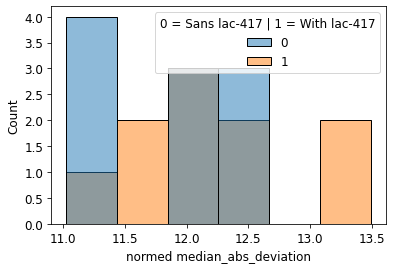

In [21]:
ax = sns.histplot(data=xdf, x="normed median_abs_deviation", hue=allocation_idx_mapped_title)

xdf.groupby(allocation_idx_mapped_title)['normed median_abs_deviation'].median().reset_index()


### Percent Outliers


In [22]:
nonoutlier_counts = df_snapshot_diffs.groupby(allocation_idx_mapped_title).agg({
    'Latency Walltime Inlet (ns)': count_nonoutliers,
}).reset_index()
nonoutlier_counts


,0 = Sans lac-417 | 1 = With lac-417,Latency Walltime Inlet (ns)
0,0,15086.0
1,1,15044.0


In [23]:
outlier_counts = df_snapshot_diffs.groupby(allocation_idx_mapped_title).agg({
    'Latency Walltime Inlet (ns)': count_outliers,
}).reset_index()
outlier_counts


,0 = Sans lac-417 | 1 = With lac-417,Latency Walltime Inlet (ns)
0,0,274.0
1,1,316.0


In [24]:
stats.chi2_contingency(
    np.vstack(
        [
            outlier_counts["Latency Walltime Inlet (ns)"],
            nonoutlier_counts["Latency Walltime Inlet (ns)"],
        ],
    ),
)


(2.9049441122368047,
 0.08830831441913926,
 1,
 array([[  295.,   295.],
        [15065., 15065.]]))

In [25]:
df_snapshot_diffs.groupby(allocation_idx_mapped_title).agg({
    'Latency Walltime Inlet (ns)': lambda x: count_proportion_outliers(x) * 100,
}).reset_index()


,0 = Sans lac-417 | 1 = With lac-417,Latency Walltime Inlet (ns)
0,0,1.783854
1,1,2.057292


### Distributions


teeplots/latency-walltime-outlet-ns/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-barplot+x=0-sans-lac-417-1-with-lac-417+y=latency-walltime-outlet-ns+ext=.pdf
skipping teeplots/latency-walltime-outlet-ns/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-barplot+x=0-sans-lac-417-1-with-lac-417+y=latency-walltime-outlet-ns+ext=.png
teeplots/latency-walltime-outlet-ns/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-withfliers+x=0-sans-lac-417-1-with-lac-417+y=latency-walltime-outlet-ns+ext=.pdf
skipping teeplots/latency-walltime-outlet-ns/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-withfliers+x=0-sans-lac-417-1-with-lac-417+y=latency-walltime-outlet-ns+ext=.png
teeplots/latency-walltime-outlet-ns/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-nofliers+x=0-sans-lac-417-1-with-lac-417+y=latency-walltime-outlet-ns+ext=.pdf
skipping teeplots/latency-walltime-outlet-ns/row=num-simels-per-cpu+transform=snapshot_diff

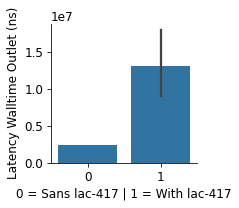

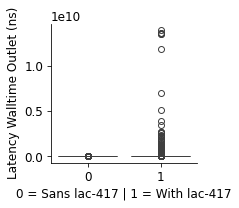

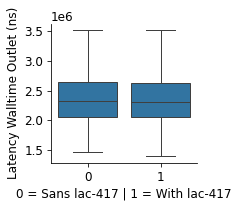

In [26]:
for viz in facet_barplot, facet_boxplot_withfliers, facet_boxplot_nofliers:
    tp.tee(
        viz,
        data=df_snapshot_diffs,
        row='Num Simels Per Cpu',
        x=allocation_idx_mapped_title,
        y='Latency Walltime Outlet (ns)',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs',
            },
            **nbm.collate_outattr_metadata(),
        },
        teeplot_subdir='latency-walltime-outlet-ns',
    )


In [27]:
# adapted from https://stackoverflow.com/a/13592901
df_snapshot_diffs.groupby([
    allocation_idx_mapped_title,
]).agg({
    'Latency Walltime Outlet (ns)' : [
        np.mean,
        np.median,
    ],
})


Latency Walltime Outlet (ns)              
                                                            mean        median
0 = Sans lac-417 | 1 = With lac-417                                           
0                                                   2.382727e+06  2.321078e+06
1                                                   1.311726e+07  2.303992e+06

## Latency Simsteps


teeplots/latency-simsteps-inlet/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-barplot+x=0-sans-lac-417-1-with-lac-417+y=latency-simsteps-inlet+ext=.pdf
skipping teeplots/latency-simsteps-inlet/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-barplot+x=0-sans-lac-417-1-with-lac-417+y=latency-simsteps-inlet+ext=.png
teeplots/latency-simsteps-inlet/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-withfliers+x=0-sans-lac-417-1-with-lac-417+y=latency-simsteps-inlet+ext=.pdf
skipping teeplots/latency-simsteps-inlet/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-withfliers+x=0-sans-lac-417-1-with-lac-417+y=latency-simsteps-inlet+ext=.png
teeplots/latency-simsteps-inlet/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-nofliers+x=0-sans-lac-417-1-with-lac-417+y=latency-simsteps-inlet+ext=.pdf
skipping teeplots/latency-simsteps-inlet/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-nofliers+x=0-sans-lac-41

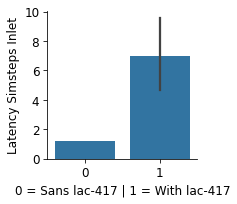

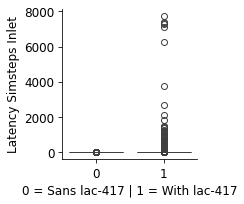

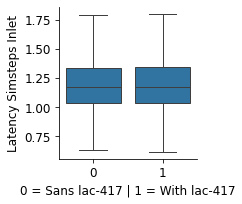

In [28]:
for viz in facet_barplot, facet_boxplot_withfliers, facet_boxplot_nofliers:
    tp.tee(
        viz,
        data=df_snapshot_diffs,
        row='Num Simels Per Cpu',
        x=allocation_idx_mapped_title,
        y='Latency Simsteps Inlet',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs',
            },
            **nbm.collate_outattr_metadata(),
        },
        teeplot_subdir='latency-simsteps-inlet',
    )


### Simple Mean and Median


In [29]:
# adapted from https://stackoverflow.com/a/13592901
df_snapshot_diffs.groupby([
    allocation_idx_mapped_title,
]).agg({
    'Latency Simsteps Inlet' : [
        np.mean,
        np.median,
    ],
})


Latency Simsteps Inlet          
                                                      mean    median
0 = Sans lac-417 | 1 = With lac-417                                 
0                                                 1.205163  1.170639
1                                                 6.964164  1.168870

### Median of Replicate Means


In [30]:
group_medians = df_snapshot_diffs.groupby([allocation_idx_mapped_title, 'Replicate']).agg({
    'Latency Simsteps Inlet': np.mean
}).reset_index()

median_of_medians = group_medians.groupby(allocation_idx_mapped_title).agg({
    'Latency Simsteps Inlet': np.mean
})

baseline = median_of_medians.loc[1, "Latency Simsteps Inlet"].squeeze()
median_of_medians["normed delta"] = (median_of_medians["Latency Simsteps Inlet"] - baseline) / baseline * 100
median_of_medians


,Latency Simsteps Inlet,normed delta
0 = Sans lac-417 | 1 = With lac-417,,
0,1.205163,-82.694786
1,6.964164,0.000000


### Median of Replicate Medians


In [31]:
group_medians = df_snapshot_diffs.groupby([allocation_idx_mapped_title, 'Replicate']).agg({
    'Latency Simsteps Inlet': np.median
}).reset_index()

median_of_medians = group_medians.groupby(allocation_idx_mapped_title).agg({
    'Latency Simsteps Inlet': np.median
})

baseline = median_of_medians.loc[1, "Latency Simsteps Inlet"].squeeze()
median_of_medians["normed delta"] = (median_of_medians["Latency Simsteps Inlet"] - baseline) / baseline * 100
median_of_medians


,Latency Simsteps Inlet,normed delta
0 = Sans lac-417 | 1 = With lac-417,,
0,1.166174,-0.380114
1,1.170624,0.000000


### Median Absolute Deviance


In [32]:
xdf = df_snapshot_diffs.copy()
xdf['median'] = xdf['Latency Simsteps Inlet']
xdf['median_abs_deviation'] = xdf['Latency Simsteps Inlet']
xdf = xdf.groupby([allocation_idx_mapped_title, 'Replicate']).agg({
    'median': np.median,
    'median_abs_deviation': stats.median_abs_deviation,
}).reset_index()
xdf["normed median_abs_deviation"] = xdf["median_abs_deviation"] / xdf["median"] * 100

name1, name2 = xdf[allocation_idx_mapped_title].unique()

# Extract medians for each group
group1 = xdf[xdf[allocation_idx_mapped_title] == name1]['normed median_abs_deviation']
group2 = xdf[xdf[allocation_idx_mapped_title] == name2]['normed median_abs_deviation']

print(len(group1), len(group2))
stats.mannwhitneyu(group1, group2)


10 10


MannwhitneyuResult(statistic=24.0, pvalue=0.026951278584693587)

,0 = Sans lac-417 | 1 = With lac-417,normed median_abs_deviation
0,0,11.835790
1,1,12.588213


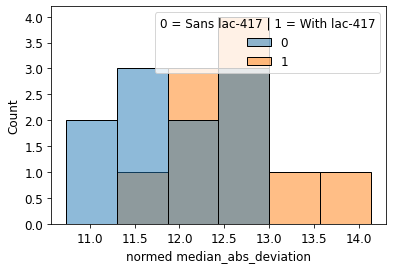

In [33]:
ax = sns.histplot(data=xdf, x="normed median_abs_deviation", hue=allocation_idx_mapped_title)

xdf.groupby(allocation_idx_mapped_title)['normed median_abs_deviation'].median().reset_index()


### Percent Outliers


In [34]:
nonoutlier_counts = df_snapshot_diffs.groupby(allocation_idx_mapped_title).agg({
    'Latency Simsteps Inlet': count_nonoutliers,
}).reset_index()
nonoutlier_counts


,0 = Sans lac-417 | 1 = With lac-417,Latency Simsteps Inlet
0,0,15073.0
1,1,15000.0


In [35]:
outlier_counts = df_snapshot_diffs.groupby(allocation_idx_mapped_title).agg({
    'Latency Simsteps Inlet': count_outliers,
}).reset_index()
outlier_counts


,0 = Sans lac-417 | 1 = With lac-417,Latency Simsteps Inlet
0,0,287.0
1,1,360.0


In [36]:
stats.chi2_contingency(
    np.vstack(
        [
            outlier_counts["Latency Simsteps Inlet"],
            nonoutlier_counts["Latency Simsteps Inlet"],
        ],
    ),
)


(8.1847453011171,
 0.004224410930862641,
 1,
 array([[  323.5,   323.5],
        [15036.5, 15036.5]]))

In [37]:
df_snapshot_diffs.groupby(allocation_idx_mapped_title).agg({
    'Latency Simsteps Inlet': lambda x: count_proportion_outliers(x) * 100,
}).reset_index()


,0 = Sans lac-417 | 1 = With lac-417,Latency Simsteps Inlet
0,0,1.86849
1,1,2.34375


teeplots/latency-simsteps-outlet/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-barplot+x=0-sans-lac-417-1-with-lac-417+y=latency-simsteps-outlet+ext=.pdf
skipping teeplots/latency-simsteps-outlet/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-barplot+x=0-sans-lac-417-1-with-lac-417+y=latency-simsteps-outlet+ext=.png
teeplots/latency-simsteps-outlet/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-withfliers+x=0-sans-lac-417-1-with-lac-417+y=latency-simsteps-outlet+ext=.pdf
skipping teeplots/latency-simsteps-outlet/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-withfliers+x=0-sans-lac-417-1-with-lac-417+y=latency-simsteps-outlet+ext=.png
teeplots/latency-simsteps-outlet/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-nofliers+x=0-sans-lac-417-1-with-lac-417+y=latency-simsteps-outlet+ext=.pdf
skipping teeplots/latency-simsteps-outlet/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-nofliers+x=0-

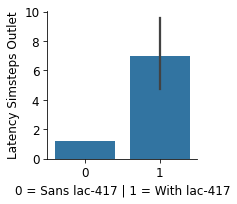

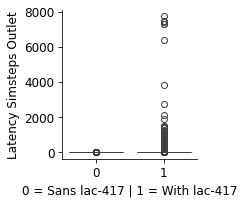

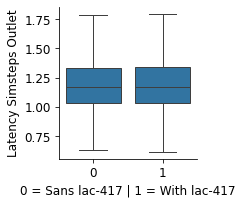

In [38]:
for viz in facet_barplot, facet_boxplot_withfliers, facet_boxplot_nofliers:
    tp.tee(
        viz,
        data=df_snapshot_diffs,
        row='Num Simels Per Cpu',
        x=allocation_idx_mapped_title,
        y='Latency Simsteps Outlet',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs',
            },
            **nbm.collate_outattr_metadata(),
        },
        teeplot_subdir='latency-simsteps-outlet',
    )


In [39]:
# adapted fmke_regr_make_regression_rowrom https://stackoverflow.com/a/13592901
df_snapshot_diffs.groupby(
    [
        allocation_idx_mapped_title,
    ]
).agg(
    {
        "Latency Simsteps Outlet": [
            np.mean,
            np.median,
        ],
    }
)


Latency Simsteps Outlet          
                                                       mean    median
0 = Sans lac-417 | 1 = With lac-417                                  
0                                                  1.203728  1.169993
1                                                  7.007604  1.168253

## Delivery Failure Rate


teeplots/delivery-failure-rate/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-barplot+x=0-sans-lac-417-1-with-lac-417+y=delivery-failure-rate+ext=.pdf
skipping teeplots/delivery-failure-rate/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-barplot+x=0-sans-lac-417-1-with-lac-417+y=delivery-failure-rate+ext=.png
teeplots/delivery-failure-rate/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-withfliers+x=0-sans-lac-417-1-with-lac-417+y=delivery-failure-rate+ext=.pdf
skipping teeplots/delivery-failure-rate/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-withfliers+x=0-sans-lac-417-1-with-lac-417+y=delivery-failure-rate+ext=.png
teeplots/delivery-failure-rate/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-nofliers+x=0-sans-lac-417-1-with-lac-417+y=delivery-failure-rate+ext=.pdf
skipping teeplots/delivery-failure-rate/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-nofliers+x=0-sans-lac-417-1-with-la

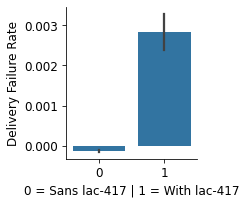

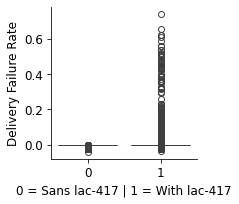

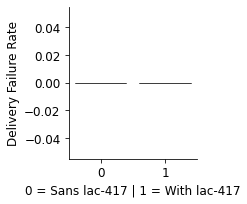

In [40]:
for viz in facet_barplot, facet_boxplot_withfliers, facet_boxplot_nofliers:
    tp.tee(
        viz,
        data=df_snapshot_diffs,
        row='Num Simels Per Cpu',
        x=allocation_idx_mapped_title,
        y='Delivery Failure Rate',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs',
            },
            **nbm.collate_outattr_metadata(),
        },
        teeplot_subdir='delivery-failure-rate',
    )


### Simple Mean and Median


In [41]:
# adapted from https://stackoverflow.com/a/13592901
df_snapshot_diffs.groupby([
    allocation_idx_mapped_title,
]).agg({
    'Delivery Failure Rate' : [
        np.mean,
        np.median,
    ],
})


Delivery Failure Rate       
                                                     mean median
0 = Sans lac-417 | 1 = With lac-417                             
0                                               -0.000119    0.0
1                                                0.002835    0.0

### Median of Replicate Means


In [42]:
group_medians = df_snapshot_diffs.groupby([allocation_idx_mapped_title, 'Replicate']).agg({
    'Delivery Failure Rate': np.mean
}).reset_index()

median_of_medians = group_medians.groupby(allocation_idx_mapped_title).agg({
    'Delivery Failure Rate': np.mean
})

baseline = median_of_medians.loc[1, "Delivery Failure Rate"].squeeze()
median_of_medians["normed delta"] = (median_of_medians["Delivery Failure Rate"] - baseline) / baseline * 100
median_of_medians


,Delivery Failure Rate,normed delta
0 = Sans lac-417 | 1 = With lac-417,,
0,-0.000119,-104.189002
1,0.002835,0.000000


### Median of Replicate Medians


In [43]:
group_medians = df_snapshot_diffs.groupby([allocation_idx_mapped_title, 'Replicate']).agg({
    'Delivery Failure Rate': np.median
}).reset_index()

median_of_medians = group_medians.groupby(allocation_idx_mapped_title).agg({
    'Delivery Failure Rate': np.median
})

baseline = median_of_medians.loc[1, "Delivery Failure Rate"].squeeze()
median_of_medians["normed delta"] = (median_of_medians["Delivery Failure Rate"] - baseline) / baseline * 100
median_of_medians


,Delivery Failure Rate,normed delta
0 = Sans lac-417 | 1 = With lac-417,,
0,0.0,NaN
1,0.0,NaN


### Median Absolute Deviance


In [44]:
xdf = df_snapshot_diffs.copy()
xdf['median'] = xdf['Delivery Failure Rate']
xdf['median_abs_deviation'] = xdf['Delivery Failure Rate']
xdf = xdf.groupby([allocation_idx_mapped_title, 'Replicate']).agg({
    'median': np.median,
    'median_abs_deviation': stats.median_abs_deviation,
}).reset_index()
xdf["normed median_abs_deviation"] = xdf["median_abs_deviation"] / xdf["median"] * 100

name1, name2 = xdf[allocation_idx_mapped_title].unique()

# Extract medians for each group
group1 = xdf[xdf[allocation_idx_mapped_title] == name1]['normed median_abs_deviation']
group2 = xdf[xdf[allocation_idx_mapped_title] == name2]['normed median_abs_deviation']

try:
    print(len(group1), len(group2))
    print(group1.isna().all(), group2.isna().all())
    res = stats.mannwhitneyu(group1, group2)
    display(res)
except Exception as e:
    warnings.warn(f"{type(e).__name__}: {e}", RuntimeWarning)


10 10
True True


MannwhitneyuResult(statistic=28.0, pvalue=0.05205494483011341)

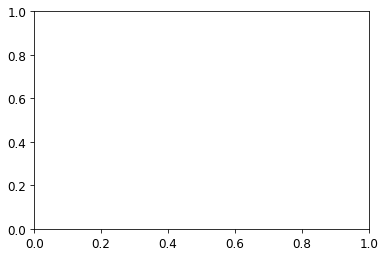

In [45]:
try:
    ax = sns.histplot(data=xdf, x="normed median_abs_deviation", hue=allocation_idx_mapped_title)
except Exception as e:
    warnings.warn(f"{type(e).__name__}: {e}", RuntimeWarning)

try:
    xdf.groupby(allocation_idx_mapped_title)['normed median_abs_deviation'].median().reset_index()
except Exception as e:
    warnings.warn(f"{type(e).__name__}: {e}", RuntimeWarning)


### Percent Outliers


In [46]:
nonoutlier_counts = df_snapshot_diffs.groupby(allocation_idx_mapped_title).agg({
    'Delivery Failure Rate': count_nonoutliers,
}).reset_index()
nonoutlier_counts


,0 = Sans lac-417 | 1 = With lac-417,Delivery Failure Rate
0,0,15249.0
1,1,14972.0


In [47]:
outlier_counts = df_snapshot_diffs.groupby(allocation_idx_mapped_title).agg({
    'Delivery Failure Rate': count_outliers,
}).reset_index()
outlier_counts


,0 = Sans lac-417 | 1 = With lac-417,Delivery Failure Rate
0,0,111.0
1,1,388.0


In [48]:
stats.chi2_contingency(
    np.vstack(
        [
            outlier_counts["Delivery Failure Rate"],
            nonoutlier_counts["Delivery Failure Rate"],
        ],
    ),
)


(155.1779459783204,
 1.2802867966260552e-35,
 1,
 array([[  249.5,   249.5],
        [15110.5, 15110.5]]))

In [49]:
df_snapshot_diffs.groupby(allocation_idx_mapped_title).agg({
    'Delivery Failure Rate': lambda x: count_proportion_outliers(x) * 100,
}).reset_index()


,0 = Sans lac-417 | 1 = With lac-417,Delivery Failure Rate
0,0,0.722656
1,1,2.526042


## Delivery Clumpiness


teeplots/delivery-clumpiness/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-barplot+x=0-sans-lac-417-1-with-lac-417+y=delivery-clumpiness+ext=.pdf
skipping teeplots/delivery-clumpiness/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-barplot+x=0-sans-lac-417-1-with-lac-417+y=delivery-clumpiness+ext=.png
teeplots/delivery-clumpiness/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-withfliers+x=0-sans-lac-417-1-with-lac-417+y=delivery-clumpiness+ext=.pdf
skipping teeplots/delivery-clumpiness/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-withfliers+x=0-sans-lac-417-1-with-lac-417+y=delivery-clumpiness+ext=.png
teeplots/delivery-clumpiness/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-nofliers+x=0-sans-lac-417-1-with-lac-417+y=delivery-clumpiness+ext=.pdf
skipping teeplots/delivery-clumpiness/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-nofliers+x=0-sans-lac-417-1-with-lac-417+y=delivery-clump

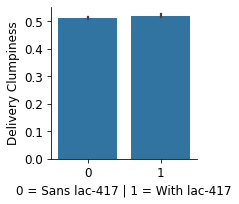

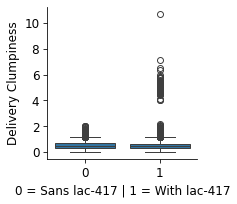

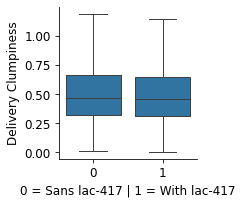

In [50]:
for viz in facet_barplot, facet_boxplot_withfliers, facet_boxplot_nofliers:
    tp.tee(
        viz,
        data=df_snapshot_diffs,
        row='Num Simels Per Cpu',
        x=allocation_idx_mapped_title,
        y='Delivery Clumpiness',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs',
            },
            **nbm.collate_outattr_metadata(),
        },
        teeplot_subdir='delivery-clumpiness',
    )


### Simple Mean and Median


In [51]:
# adapted from https://stackoverflow.com/a/13592901
df_snapshot_diffs.groupby([
    allocation_idx_mapped_title,
]).agg({
    'Delivery Clumpiness' : [
        np.mean,
        np.median,
    ],
})


Delivery Clumpiness          
                                                   mean    median
0 = Sans lac-417 | 1 = With lac-417                              
0                                              0.511329  0.469683
1                                              0.520776  0.453913

### Median of Replicate Means


In [52]:
group_medians = df_snapshot_diffs.groupby([allocation_idx_mapped_title, 'Replicate']).agg({
    'Delivery Clumpiness': np.mean
}).reset_index()

median_of_medians = group_medians.groupby(allocation_idx_mapped_title).agg({
    'Delivery Clumpiness': np.mean
})

baseline = median_of_medians.loc[1, "Delivery Clumpiness"].squeeze()
median_of_medians["normed delta"] = (median_of_medians["Delivery Clumpiness"] - baseline) / baseline * 100
median_of_medians


,Delivery Clumpiness,normed delta
0 = Sans lac-417 | 1 = With lac-417,,
0,0.511329,-1.814021
1,0.520776,0.000000


### Median of Replicate Medians


In [53]:
group_medians = df_snapshot_diffs.groupby([allocation_idx_mapped_title, 'Replicate']).agg({
    'Delivery Clumpiness': np.median
}).reset_index()

median_of_medians = group_medians.groupby(allocation_idx_mapped_title).agg({
    'Delivery Clumpiness': np.median
})

baseline = median_of_medians.loc[1, "Delivery Clumpiness"].squeeze()
median_of_medians["normed delta"] = (median_of_medians["Delivery Clumpiness"] - baseline) / baseline * 100
median_of_medians


,Delivery Clumpiness,normed delta
0 = Sans lac-417 | 1 = With lac-417,,
0,0.464752,0.691358
1,0.461561,0.000000


### Median Absolute Deviance


In [54]:
xdf = df_snapshot_diffs.copy()
xdf['median'] = xdf['Delivery Clumpiness']
xdf['median_abs_deviation'] = xdf['Delivery Clumpiness']
xdf = xdf.groupby([allocation_idx_mapped_title, 'Replicate']).agg({
    'median': np.median,
    'median_abs_deviation': stats.median_abs_deviation,
}).reset_index()
xdf["normed median_abs_deviation"] = xdf["median_abs_deviation"] / xdf["median"] * 100

name1, name2 = xdf[allocation_idx_mapped_title].unique()

# Extract medians for each group
group1 = xdf[xdf[allocation_idx_mapped_title] == name1]['normed median_abs_deviation']
group2 = xdf[xdf[allocation_idx_mapped_title] == name2]['normed median_abs_deviation']

print(len(group1), len(group2))
stats.mannwhitneyu(group1, group2)


10 10


MannwhitneyuResult(statistic=46.0, pvalue=0.3956683900503302)

,0 = Sans lac-417 | 1 = With lac-417,normed median_abs_deviation
0,0,34.815971
1,1,34.029565


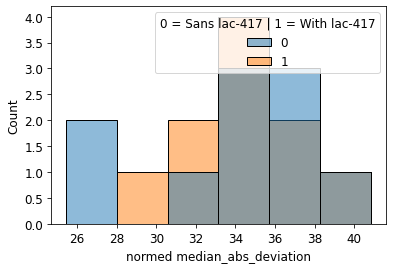

In [55]:
ax = sns.histplot(data=xdf, x="normed median_abs_deviation", hue=allocation_idx_mapped_title)

xdf.groupby(allocation_idx_mapped_title)['normed median_abs_deviation'].median().reset_index()


### Percent Outliers


In [56]:
nonoutlier_counts = df_snapshot_diffs.groupby(allocation_idx_mapped_title).agg({
    'Delivery Clumpiness': count_nonoutliers,
}).reset_index()
nonoutlier_counts


,0 = Sans lac-417 | 1 = With lac-417,Delivery Clumpiness
0,0,15146.0
1,1,14983.0


In [57]:
outlier_counts = df_snapshot_diffs.groupby(allocation_idx_mapped_title).agg({
    'Delivery Clumpiness': count_outliers,
}).reset_index()
outlier_counts


,0 = Sans lac-417 | 1 = With lac-417,Delivery Clumpiness
0,0,214.0
1,1,377.0


In [58]:
stats.chi2_contingency(
    np.vstack(
        [
            outlier_counts["Delivery Clumpiness"],
            nonoutlier_counts["Delivery Clumpiness"],
        ],
    ),
)


(45.27714583635545,
 1.7103337417298998e-11,
 1,
 array([[  295.5,   295.5],
        [15064.5, 15064.5]]))

In [59]:
df_snapshot_diffs.groupby(allocation_idx_mapped_title).agg({
    'Delivery Clumpiness': lambda x: count_proportion_outliers(x) * 100,
}).reset_index()


,0 = Sans lac-417 | 1 = With lac-417,Delivery Clumpiness
0,0,1.393229
1,1,2.454427


## Simstep Period


teeplots/simstep-period-inlet-ns/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-barplot+x=0-sans-lac-417-1-with-lac-417+y=simstep-period-inlet-ns+ext=.pdf
skipping teeplots/simstep-period-inlet-ns/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-barplot+x=0-sans-lac-417-1-with-lac-417+y=simstep-period-inlet-ns+ext=.png
teeplots/simstep-period-inlet-ns/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-withfliers+x=0-sans-lac-417-1-with-lac-417+y=simstep-period-inlet-ns+ext=.pdf
skipping teeplots/simstep-period-inlet-ns/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-withfliers+x=0-sans-lac-417-1-with-lac-417+y=simstep-period-inlet-ns+ext=.png
teeplots/simstep-period-inlet-ns/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-nofliers+x=0-sans-lac-417-1-with-lac-417+y=simstep-period-inlet-ns+ext=.pdf
skipping teeplots/simstep-period-inlet-ns/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-nofliers+x=0-

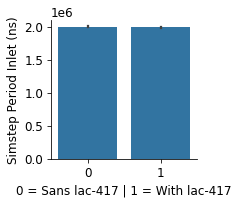

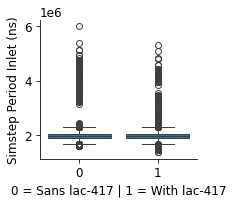

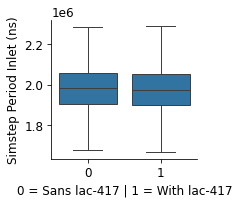

In [60]:
for viz in facet_barplot, facet_boxplot_withfliers, facet_boxplot_nofliers:
    tp.tee(
        viz,
        data=df_snapshot_diffs,
        row='Num Simels Per Cpu',
        x=allocation_idx_mapped_title,
        y='Simstep Period Inlet (ns)',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs',
            },
            **nbm.collate_outattr_metadata(),
        },
        teeplot_subdir='simstep-period-inlet-ns',
    )


### Simple Mean and Median


In [61]:
# adapted from https://stackoverflow.com/a/13592901
df_snapshot_diffs.groupby([
    allocation_idx_mapped_title,
]).agg({
    'Simstep Period Inlet (ns)' : [
        np.mean,
        np.median,
    ],
})


Simstep Period Inlet (ns)              
                                                         mean        median
0 = Sans lac-417 | 1 = With lac-417                                        
0                                                2.005570e+06  1.982170e+06
1                                                1.991855e+06  1.973296e+06

### Median of Replicate Means


In [62]:
group_medians = df_snapshot_diffs.groupby([allocation_idx_mapped_title, 'Replicate']).agg({
    'Simstep Period Inlet (ns)': np.mean
}).reset_index()

median_of_medians = group_medians.groupby(allocation_idx_mapped_title).agg({
    'Simstep Period Inlet (ns)': np.mean
})

baseline = median_of_medians.loc[1, "Simstep Period Inlet (ns)"].squeeze()
median_of_medians["normed delta"] = (median_of_medians["Simstep Period Inlet (ns)"] - baseline) / baseline * 100
median_of_medians


,Simstep Period Inlet (ns),normed delta
0 = Sans lac-417 | 1 = With lac-417,,
0,2.005570e+06,0.688538
1,1.991855e+06,0.000000


### Median of Replicate Medians


In [63]:
group_medians = df_snapshot_diffs.groupby([allocation_idx_mapped_title, 'Replicate']).agg({
    'Simstep Period Inlet (ns)': np.median
}).reset_index()

median_of_medians = group_medians.groupby(allocation_idx_mapped_title).agg({
    'Simstep Period Inlet (ns)': np.median
})

baseline = median_of_medians.loc[1, "Simstep Period Inlet (ns)"].squeeze()
median_of_medians["normed delta"] = (median_of_medians["Simstep Period Inlet (ns)"] - baseline) / baseline * 100
median_of_medians


,Simstep Period Inlet (ns),normed delta
0 = Sans lac-417 | 1 = With lac-417,,
0,1.982734e+06,0.505743
1,1.972757e+06,0.000000


### Median Absolute Deviance


In [64]:
xdf = df_snapshot_diffs.copy()
xdf['median'] = xdf['Simstep Period Inlet (ns)']
xdf['median_abs_deviation'] = xdf['Simstep Period Inlet (ns)']
xdf = xdf.groupby([allocation_idx_mapped_title, 'Replicate']).agg({
    'median': np.median,
    'median_abs_deviation': stats.median_abs_deviation,
}).reset_index()
xdf["normed median_abs_deviation"] = xdf["median_abs_deviation"] / xdf["median"] * 100

name1, name2 = xdf[allocation_idx_mapped_title].unique()

# Extract medians for each group
group1 = xdf[xdf[allocation_idx_mapped_title] == name1]['normed median_abs_deviation']
group2 = xdf[xdf[allocation_idx_mapped_title] == name2]['normed median_abs_deviation']

print(len(group1), len(group2))
stats.mannwhitneyu(group1, group2)


10 10


MannwhitneyuResult(statistic=30.0, pvalue=0.07023252407917747)

,0 = Sans lac-417 | 1 = With lac-417,normed median_abs_deviation
0,0,3.854203
1,1,3.988987


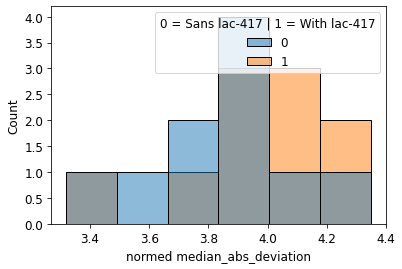

In [65]:
ax = sns.histplot(data=xdf, x="normed median_abs_deviation", hue=allocation_idx_mapped_title)

xdf.groupby(allocation_idx_mapped_title)['normed median_abs_deviation'].median().reset_index()


### Percent Outliers


In [66]:
nonoutlier_counts = df_snapshot_diffs.groupby(allocation_idx_mapped_title).agg({
    'Simstep Period Inlet (ns)': count_nonoutliers,
}).reset_index()
nonoutlier_counts


,0 = Sans lac-417 | 1 = With lac-417,Simstep Period Inlet (ns)
0,0,14911.0
1,1,14951.0


In [67]:
outlier_counts = df_snapshot_diffs.groupby(allocation_idx_mapped_title).agg({
    'Simstep Period Inlet (ns)': count_outliers,
}).reset_index()
outlier_counts


,0 = Sans lac-417 | 1 = With lac-417,Simstep Period Inlet (ns)
0,0,449.0
1,1,409.0


In [68]:
stats.chi2_contingency(
    np.vstack(
        [
            outlier_counts["Simstep Period Inlet (ns)"],
            nonoutlier_counts["Simstep Period Inlet (ns)"],
        ],
    ),
)


(1.8236615704970134,
 0.17687804747517222,
 1,
 array([[  429.,   429.],
        [14931., 14931.]]))

In [69]:
df_snapshot_diffs.groupby(allocation_idx_mapped_title).agg({
    'Simstep Period Inlet (ns)': lambda x: count_proportion_outliers(x) * 100,
}).reset_index()


,0 = Sans lac-417 | 1 = With lac-417,Simstep Period Inlet (ns)
0,0,2.923177
1,1,2.662760


teeplots/simstep-period-outlet-ns/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-barplot+x=0-sans-lac-417-1-with-lac-417+y=simstep-period-outlet-ns+ext=.pdf
skipping teeplots/simstep-period-outlet-ns/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-barplot+x=0-sans-lac-417-1-with-lac-417+y=simstep-period-outlet-ns+ext=.png
teeplots/simstep-period-outlet-ns/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-withfliers+x=0-sans-lac-417-1-with-lac-417+y=simstep-period-outlet-ns+ext=.pdf
skipping teeplots/simstep-period-outlet-ns/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-withfliers+x=0-sans-lac-417-1-with-lac-417+y=simstep-period-outlet-ns+ext=.png
teeplots/simstep-period-outlet-ns/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-nofliers+x=0-sans-lac-417-1-with-lac-417+y=simstep-period-outlet-ns+ext=.pdf
skipping teeplots/simstep-period-outlet-ns/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-no

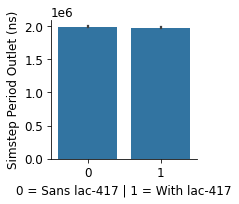

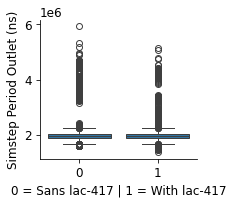

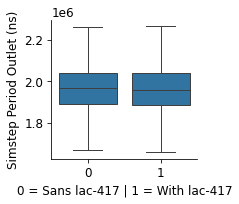

In [70]:
for viz in facet_barplot, facet_boxplot_withfliers, facet_boxplot_nofliers:
    tp.tee(
        viz,
        data=df_snapshot_diffs,
        row='Num Simels Per Cpu',
        x=allocation_idx_mapped_title,
        y='Simstep Period Outlet (ns)',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs',
            },
            **nbm.collate_outattr_metadata(),
        },
        teeplot_subdir='simstep-period-outlet-ns',
    )


In [71]:
# adapted from https://stackoverflow.com/a/13592901
df_snapshot_diffs.groupby([
    allocation_idx_mapped_title,
]).agg({
    'Simstep Period Outlet (ns)' : [
        np.mean,
        np.median,
    ],
})


Simstep Period Outlet (ns)              
                                                          mean        median
0 = Sans lac-417 | 1 = With lac-417                                         
0                                                 1.991139e+06  1.967188e+06
1                                                 1.977688e+06  1.959158e+06

# Model Fits


In [72]:
from conduitpylib.wrangle import make_regression_row


In [73]:
dependent_variables = [
    'Latency Walltime Inlet (ns)',
    'Latency Walltime Outlet (ns)',
    'Latency Simsteps Inlet',
    'Latency Simsteps Outlet',
    'Delivery Failure Rate',
    'Delivery Clumpiness',
    'Simstep Period Inlet (ns)',
    'Simstep Period Outlet (ns)',
]

# best-case approximation to replace infs/nans
# see listings of infs/nans below
df_snapshot_diffs_copy = df_snapshot_diffs.copy()
df_snapshot_diffs_copy['Latency Walltime Inlet (ns)'] = (
    df_snapshot_diffs_copy['Inlet-Nanoseconds Elapsed']
    / np.maximum(df_snapshot_diffs_copy['Num Round Trip Touches Inlet'], 1)
)
df_snapshot_diffs_copy['Latency Walltime Outlet (ns)'] = (
    df_snapshot_diffs_copy['Outlet-Nanoseconds Elapsed']
    / np.maximum(df_snapshot_diffs_copy['Num Round Trip Touches Outlet'], 1)
)
df_snapshot_diffs_copy['Latency Simsteps Inlet'] = (
    df_snapshot_diffs_copy['Num Puts Attempted']
    / np.maximum(df_snapshot_diffs_copy['Num Round Trip Touches Inlet'], 1)
)
df_snapshot_diffs_copy['Latency Simsteps Outlet'] = (
    df_snapshot_diffs_copy['Num Pulls Attempted']
    / np.maximum(df_snapshot_diffs_copy['Num Round Trip Touches Outlet'], 1)
)
df_snapshot_diffs_copy['Simstep Period Inlet (ns)'] = (
    df_snapshot_diffs_copy['Inlet-Nanoseconds Elapsed']
    / np.maximum(df_snapshot_diffs_copy['Num Puts Attempted'], 1)
)
df_snapshot_diffs_copy['Simstep Period Outlet (ns)'] = (
    df_snapshot_diffs_copy['Outlet-Nanoseconds Elapsed']
    / np.maximum(df_snapshot_diffs_copy['Num Pulls Attempted'], 1)
)

regression_data_tuples = [
    (
        'Quantile Regression over Means',
        df_snapshot_diffs.groupby([
            'Execution Instance UUID',
        ]).mean().reset_index().astype({
            'Num Processes' : 'int64',
            'Allocated Tasks Per Node' : 'int64',
            'Cpus Per Node' : 'int64',
            'Num Simels Per Cpu' : 'int64',
        })
    ),
    (
        'Quantile Regression over Medians',
        df_snapshot_diffs.groupby([
            'Execution Instance UUID',
        ]).median().reset_index().astype({
            'Num Processes' : 'int64',
            'Allocated Tasks Per Node' : 'int64',
            'Cpus Per Node' : 'int64',
            'Num Simels Per Cpu' : 'int64',
        })
    ),
]

row_filters = [
    'lambda row: True',
]

regression_results = pd.DataFrame.from_records([
    make_regression_row(
        data=data_subset,
        independent_variable=allocation_idx_mapped_title,
        dependent_variable=dependent_variable,
        regression=regression,
        row_filter=row_filter,
    )
    for row_filter in row_filters
    for regression, data in regression_data_tuples
    for _, data_subset in data.groupby([
        'Num Simels Per Cpu',
    ])
    for dependent_variable in dependent_variables
])


In [74]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

regression_results[ ~np.isfinite(regression_results['p']) ]


,Independent Variable,Dependent Variable,Dependent Variable Slug,Cpus Per Node,Num Simels Per Cpu,Slope Estimate,Slope Estimate 95% CI Lower Bound,Slope Estimate 95% CI Upper Bound,Absolute Effect Size,Absolute Effect Size 95% CI Lower Bound,Absolute Effect Size 95% CI Upper Bound,Absolute Effect Size 95% CI Width,Relative Effect Size,Relative Effect Size 95% CI Lower Bound,Relative Effect Size 95% CI Upper Bound,Relative Effect Size 95% CI Width,Intercept Estimate,Intercept Estimate 95% CI Lower Bound,Intercept Estimate 95% CI Upper Bound,R^2,p,Significant?,Significant Effect Sign,n,Filter,Num Processes,Num Processes Prettyprint,Regression Model,Regression Model Slug,Statistic
12,0 = Sans lac-417 | 1 = With lac-417,Delivery Failure Rate,delivery-failure-rate,1,2048,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,None,None,20,lambda row: True,256,256,Quantile Regression over Medians,quantile-regression-over-medians,median


In [75]:
input_attrs = pd.DataFrame.from_records([
    {
        k : v
        for k, v in kn.unpack(source_filename).items()
        if k and k[0] != '_' and k != 'ext'
    }
    for source_filename in [
        *merge_df['Source File Inlet'].unique(),
        *merge_df['Source File Outlet'].unique(),
    ]
]).dropna(
    axis='columns',
    how='any',
)

out_filename = lambda readability: kn.pack({
    **{
        col : ib.dub(input_attrs[col])
        for col in input_attrs.columns
    },
    **{
        'a' : 'with_lac_417_vs_sans_lac_417_regression_results',
        'readability' : readability,
        'ext' : '.csv',
    },
})

out_filepath = f"outplots/{out_filename('human')}"
print(out_filepath)

pathlib.Path('outplots').mkdir(parents=True, exist_ok=True)
regression_results.to_csv(
    out_filepath,
    index=False,
)

out_filepath = f"outplots/{out_filename('latexcsvreader')}"
print(out_filepath)

pathlib.Path('outplots').mkdir(parents=True, exist_ok=True)
regression_results.rename(
    columns=lambda col: ''.join(filter(str.isalnum, col)),
).to_csv(
    out_filepath,
    index=False,
    float_format=lambda col: [
        '{:_.0f}'.format(float(f'{x:.2g}')).replace('_', "'")
         if 10 < abs(x) < 10e5
         else f'{x:.2g}' for x in col
    ],
    na_rep='NaN',
)


outplots/a=with_lac_417_vs_sans_lac_417_regression_results+async_mode=3+comp_work=0+impl=proc+nproc=256+nthread=1+proc=0-255+readability=human+replicate=0-9+slurm_nnodes=256+slurm_ntasks=256+subject=inlet~outlet+view=summary+ext=.csv
outplots/a=with_lac_417_vs_sans_lac_417_regression_results+async_mode=3+comp_work=0+impl=proc+nproc=256+nthread=1+proc=0-255+readability=latexcsvreader+replicate=0-9+slurm_nnodes=256+slurm_ntasks=256+subject=inlet~outlet+view=summary+ext=.csv


In [76]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
regression_results


,Independent Variable,Dependent Variable,Dependent Variable Slug,Cpus Per Node,Num Simels Per Cpu,Slope Estimate,Slope Estimate 95% CI Lower Bound,Slope Estimate 95% CI Upper Bound,Absolute Effect Size,Absolute Effect Size 95% CI Lower Bound,Absolute Effect Size 95% CI Upper Bound,Absolute Effect Size 95% CI Width,Relative Effect Size,Relative Effect Size 95% CI Lower Bound,Relative Effect Size 95% CI Upper Bound,Relative Effect Size 95% CI Width,Intercept Estimate,Intercept Estimate 95% CI Lower Bound,Intercept Estimate 95% CI Upper Bound,R^2,p,Significant?,Significant Effect Sign,n,Filter,Num Processes,Num Processes Prettyprint,Regression Model,Regression Model Slug,Statistic
0,0 = Sans lac-417 | 1 = With lac-417,Latency Walltime Inlet (ns),latency-walltime-inlet-ns,1,2048,9.731541e+06,8.503667e+06,1.095941e+07,9.731541e+06,8.503667e+06,1.095941e+07,2.455748e+06,4.050209,3.539175,4.561242,1.022067,2.402255e+06,1.534017e+06,3.270493e+06,NaN,2.219440e-12,True,+,20,lambda row: True,256,256,Quantile Regression over Means,quantile-regression-over-means,mean
1,0 = Sans lac-417 | 1 = With lac-417,Latency Walltime Outlet (ns),latency-walltime-outlet-ns,1,2048,9.795169e+06,8.529758e+06,1.106058e+07,9.795169e+06,8.529758e+06,1.106058e+07,2.530822e+06,4.110906,3.579829,4.641983,1.062153,2.380949e+06,1.486168e+06,3.275730e+06,NaN,3.309583e-12,True,+,20,lambda row: True,256,256,Quantile Regression over Means,quantile-regression-over-means,mean
2,0 = Sans lac-417 | 1 = With lac-417,Latency Simsteps Inlet,latency-simsteps-inlet,1,2048,5.234957e+00,4.565742e+00,5.904172e+00,5.234957e+00,4.565742e+00,5.904172e+00,1.338430e+00,4.343773,3.788483,4.899063,1.110580,1.204001e+00,7.307943e-01,1.677207e+00,NaN,2.770107e-12,True,+,20,lambda row: True,256,256,Quantile Regression over Means,quantile-regression-over-means,mean
3,0 = Sans lac-417 | 1 = With lac-417,Latency Simsteps Outlet,latency-simsteps-outlet,1,2048,5.303599e+00,4.596479e+00,6.010719e+00,5.303599e+00,4.596479e+00,6.010719e+00,1.414239e+00,4.405977,3.818536,4.993418,1.174882,1.202195e+00,7.021863e-01,1.702204e+00,NaN,5.636806e-12,True,+,20,lambda row: True,256,256,Quantile Regression over Means,quantile-regression-over-means,mean
4,0 = Sans lac-417 | 1 = With lac-417,Delivery Failure Rate,delivery-failure-rate,1,2048,2.953242e-03,2.617158e-03,3.289325e-03,2.953242e-03,2.617158e-03,3.289325e-03,6.721673e-04,-24.872032,-22.041554,-27.702509,-5.660954,-1.187375e-04,-3.563845e-04,1.189096e-04,NaN,3.818480e-13,True,+,20,lambda row: True,256,256,Quantile Regression over Means,quantile-regression-over-means,mean
5,0 = Sans lac-417 | 1 = With lac-417,Delivery Clumpiness,delivery-clumpiness,1,2048,1.286848e-02,-3.501339e-02,6.075034e-02,1.286848e-02,-3.501339e-02,6.075034e-02,9.576373e-02,0.025167,-0.068475,0.118809,0.187284,5.113293e-01,4.774717e-01,5.451869e-01,NaN,5.792928e-01,False,0,20,lambda row: True,256,256,Quantile Regression over Means,quantile-regression-over-means,mean
6,0 = Sans lac-417 | 1 = With lac-417,Simstep Period Inlet (ns),simstep-period-inlet-ns,1,2048,-1.416807e+04,-2.387948e+04,-4.456659e+03,-1.416807e+04,-2.387948e+04,-4.456659e+03,1.942283e+04,-0.007064,-0.011907,-0.002222,0.009684,2.006023e+06,1.999156e+06,2.012890e+06,NaN,6.669691e-03,True,-,20,lambda row: True,256,256,Quantile Regression over Means,quantile-regression-over-means,mean
7,0 = Sans lac-417 | 1 = With lac-417,Simstep Period Outlet (ns),simstep-period-outlet-ns,1,2048,-1.354802e+04,-2.274948e+04,-4.346561e+03,-1.354802e+04,-2.274948e+04,-4.346561e+03,1.840292e+04,-0.006804,-0.011425,-0.002183,0.009242,1.991139e+06,1.984632e+06,1.997645e+06,NaN,6.269850e-03,True,-,20,lambda row: True,256,256,Quantile Regression over Means,quantile-regression-over-means,mean
8,0 = Sans lac-417 | 1 = With lac-417,Latency Walltime Inlet (ns),latency-walltime-inlet-ns,1,2048,-9.842342e+03,-1.071104e+05,8.742570e+04,-9.842342e+03,-1.071104e+05,8.742570e+04,1.945361e+05,-0.004218,-0.045902,0.037466,0.083368,2.335924e+06,2.26714

In [77]:
from conduitpylib.viz import errplot, facet_errplot


teeplots/./estimated-statistic=mean+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+x=dependent-variable+y=relative-effect-size+ext=.pdf
skipping teeplots/./estimated-statistic=mean+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+x=dependent-variable+y=relative-effect-size+ext=.png
teeplots/./estimated-statistic=median+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+x=dependent-variable+y=relative-effect-size+ext=.pdf
skipping teeplots/./estimated-statistic=median+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+x=dependent-variable+y=relative-effect-size+ext=.png


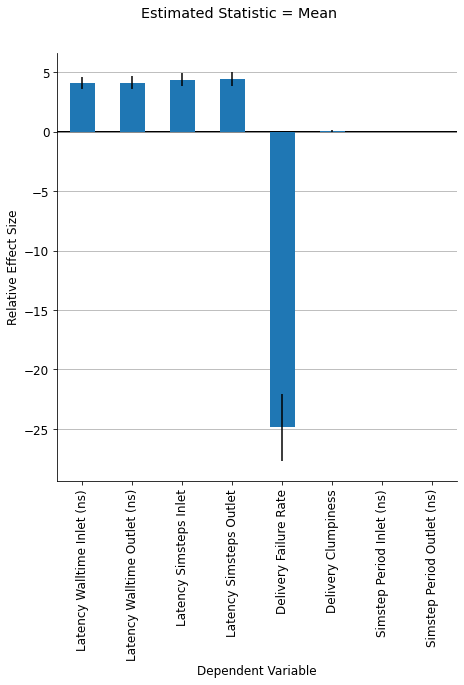

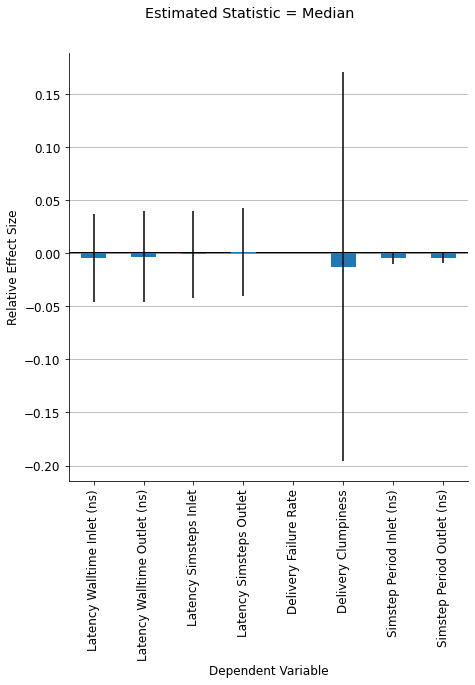

In [78]:
for regression, subset in regression_results.groupby([
    'Regression Model',
]):
    tp.tee(
        # prevent filename length error
        lambda *args, **kwargs: facet_errplot(
            err_lb='Relative Effect Size 95% CI Lower Bound',
            err_ub='Relative Effect Size 95% CI Upper Bound',
            *args,
            **kwargs,
        ),
        data=subset,

        row='Num Simels Per Cpu',
        x='Dependent Variable',
        y='Relative Effect Size',
        estimated_statistic={
            'Quantile Regression over Medians' : 'Median',
            'Quantile Regression over Means' : 'Mean',
        }[regression],
        size_inches=(8, 8),
        teeplot_outattrs={
            **{
                'transform' : 'fit_regression',
            },
            **nbm.collate_outattr_metadata(),
        },
    )


teeplots/delivery-clumpiness/estimated-statistic=delivery-clumpiness-mean+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.pdf
skipping teeplots/delivery-clumpiness/estimated-statistic=delivery-clumpiness-mean+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.png
teeplots/delivery-failure-rate/estimated-statistic=delivery-failure-rate-mean+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.pdf
skipping teeplots/delivery-failure-rate/estimated-statistic=delivery-failure-rate-mean+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.png
teeplots/latency-simsteps-inlet/estimated-statistic=latency-simsteps-inlet-mean+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.pdf
skipping teeplots/latency-simsteps-inlet/estimated-statistic=latency-simsteps-inlet-mean+row=num-simels-per-cpu+transform=fit_regression+viz=la

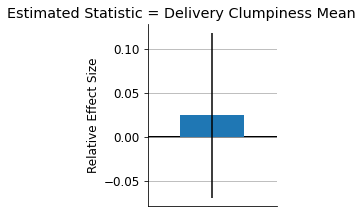

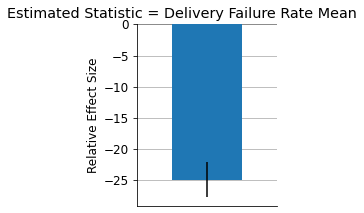

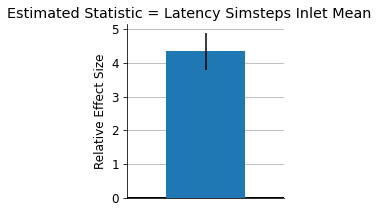

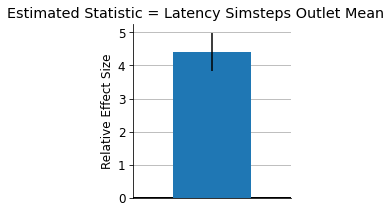

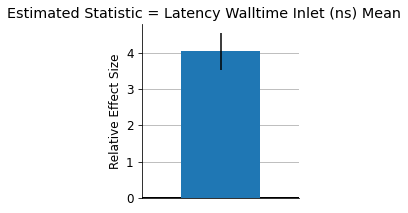

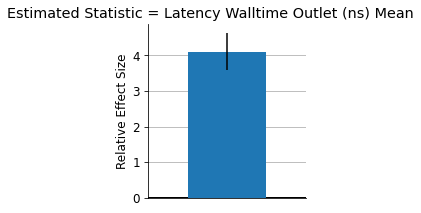

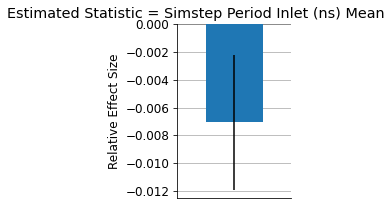

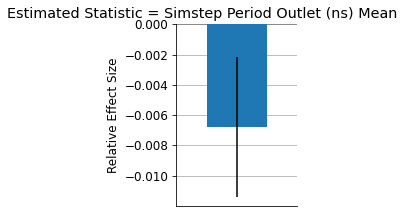

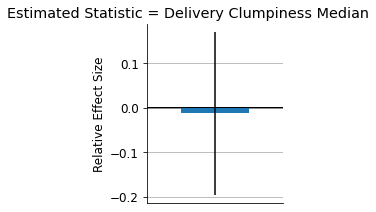

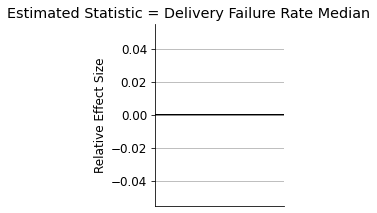

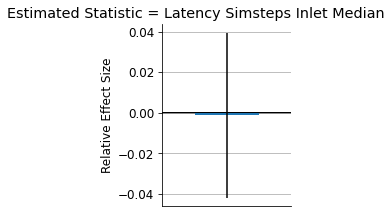

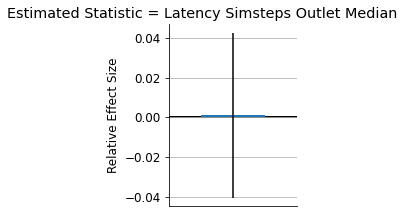

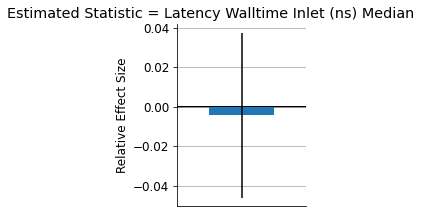

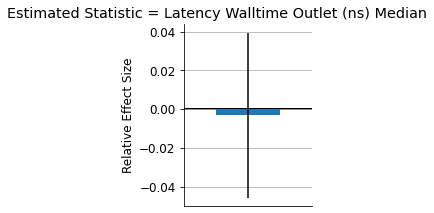

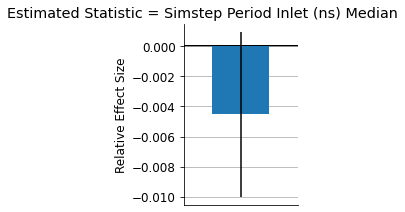

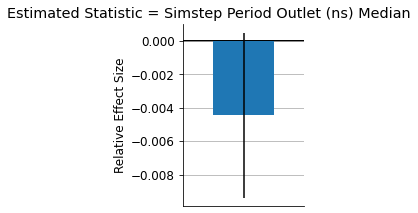

In [79]:
# relative estimates, alternate

for (regression, dependent_variable), subset in regression_results.groupby([
    'Regression Model',
    'Dependent Variable',
]):
    tp.tee(
        # prevent filename length error
        lambda *args, **kwargs: facet_errplot(
            err_lb='Relative Effect Size 95% CI Lower Bound',
            err_ub='Relative Effect Size 95% CI Upper Bound',
            *args,
            **kwargs,
        ),
        data=subset,

        row='Num Simels Per Cpu',
        y='Relative Effect Size',
        estimated_statistic={
            'Quantile Regression over Medians' : f'{dependent_variable} Median',
            'Quantile Regression over Means' : f'{dependent_variable} Mean',
        }[regression],
        teeplot_outattrs={
            **{
                'transform' : 'fit_regression',
            },
            **nbm.collate_outattr_metadata(),
        },
        teeplot_subdir=slugify(dependent_variable),
    )


teeplots/delivery-clumpiness/estimated-statistic=delivery-clumpiness-mean+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=absolute-effect-size+ext=.pdf
skipping teeplots/delivery-clumpiness/estimated-statistic=delivery-clumpiness-mean+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=absolute-effect-size+ext=.png
teeplots/delivery-failure-rate/estimated-statistic=delivery-failure-rate-mean+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=absolute-effect-size+ext=.pdf
skipping teeplots/delivery-failure-rate/estimated-statistic=delivery-failure-rate-mean+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=absolute-effect-size+ext=.png
teeplots/latency-simsteps-inlet/estimated-statistic=latency-simsteps-inlet-mean+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=absolute-effect-size+ext=.pdf
skipping teeplots/latency-simsteps-inlet/estimated-statistic=latency-simsteps-inlet-mean+row=num-simels-per-cpu+transform=fit_regression+viz=la

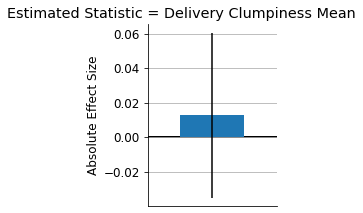

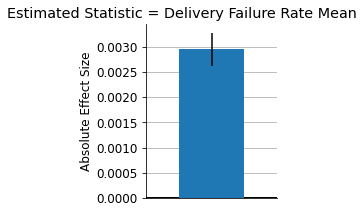

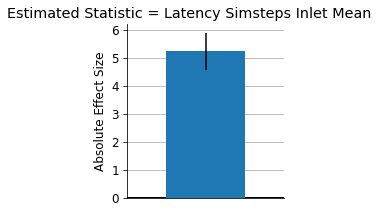

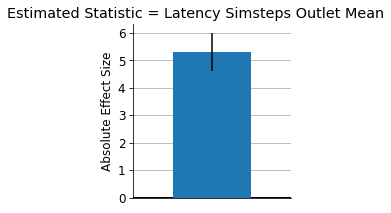

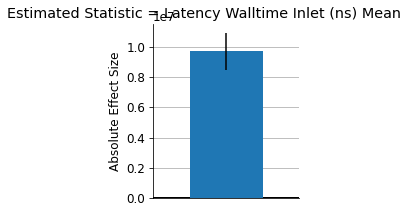

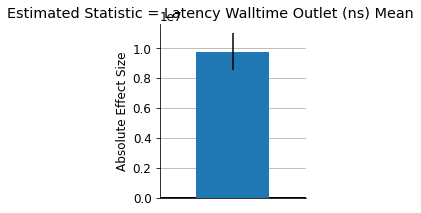

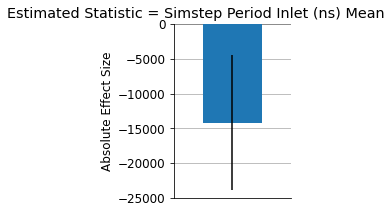

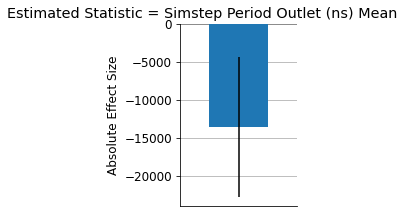

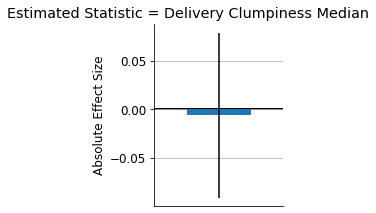

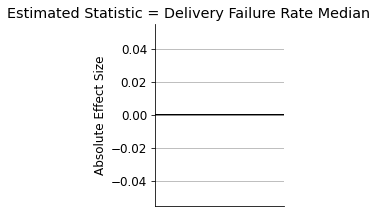

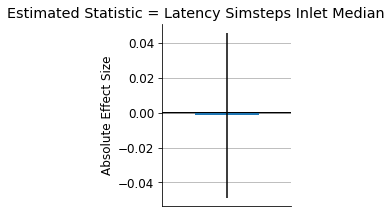

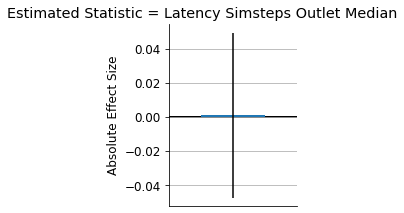

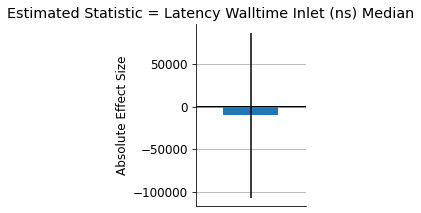

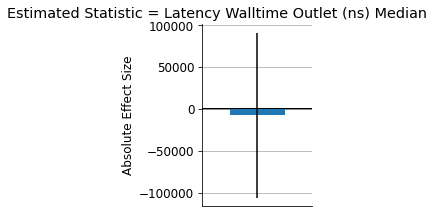

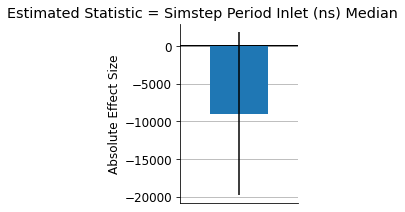

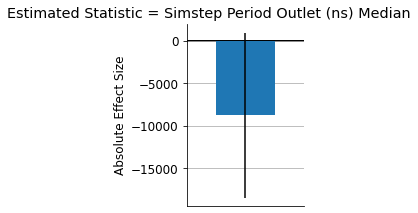

In [80]:
# absolute estimates

for (regression, dependent_variable), subset in regression_results.groupby([
    'Regression Model',
    'Dependent Variable',
]):
    tp.tee(
        # prevent filename length error
        lambda *args, **kwargs: facet_errplot(
            err_lb='Absolute Effect Size 95% CI Lower Bound',
            err_ub='Absolute Effect Size 95% CI Upper Bound',
            *args,
            **kwargs,
        ),
        data=subset,

        row='Num Simels Per Cpu',
        y='Absolute Effect Size',
        estimated_statistic={
            'Quantile Regression over Medians' : f'{dependent_variable} Median',
            'Quantile Regression over Means' : f'{dependent_variable} Mean',
        }[regression],
        teeplot_outattrs={
            **{
                'transform' : 'fit_regression',
            },
            **nbm.collate_outattr_metadata(),
        },
        teeplot_subdir=slugify(dependent_variable),
    )


In [81]:
from conduitpylib.viz import quantile_regplot


In [82]:
from conduitpylib.viz import unsplit_regression, facet_unsplit_regression


## Latency Walltime Inlet (ns)


In [83]:
df_snapshot_diffs[
    ~np.isfinite(df_snapshot_diffs['Latency Walltime Inlet (ns)'])
][[
    'Latency Walltime Inlet (ns)',
    'Latency Walltime Outlet (ns)',
    'Snapshot',
    'Runtime Seconds Elapsed Outlet',
    'Hostname',
    'Replicate',
    'Num Simels Per Cpu',
    'Cpus Per Node',
    'Num Processes',
]]


,Latency Walltime Inlet (ns),Latency Walltime Outlet (ns),Snapshot,Runtime Seconds Elapsed Outlet,Hostname,Replicate,Num Simels Per Cpu,Cpus Per Node,Num Processes


teeplots/latency-walltime-inlet-ns/marker=+regression=ordinary-least-squares-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-mean+viz=facet-unsplit-regression+x=0-sans-lac-417-1-with-lac-417+y=latency-w.../alltime-inlet-ns+ext=.pdf
skipping teeplots/latency-walltime-inlet-ns/marker=+regression=ordinary-least-squares-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-mean+viz=facet-unsplit-regression+x=0-sans-lac-417-1-with-lac-417+y=latency-w.../alltime-inlet-ns+ext=.png


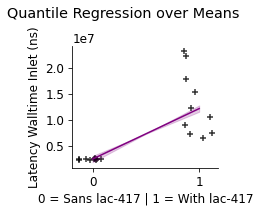

In [84]:
df_snapshot_diffs_copy = df_snapshot_diffs.copy()

# best-case approximation to replace infs/nans
# see listing of infs/nans above
df_snapshot_diffs_copy['Latency Walltime Inlet (ns)'] = (
    df_snapshot_diffs_copy['Inlet-Nanoseconds Elapsed']
    / np.maximum(df_snapshot_diffs_copy['Num Round Trip Touches Inlet'], 1)
)

data = df_snapshot_diffs_copy.groupby([
    'Execution Instance UUID',
]).mean().reset_index().astype({
    'Num Processes' : 'int64',
    'Allocated Tasks Per Node' : 'int64',
    'Cpus Per Node' : 'int64',
    'Num Simels Per Cpu' : 'int64',
    allocation_idx_mapped_title : 'int64',
})

for viz in facet_unsplit_regression,:
    tp.tee(
        viz,
        data=data,
        row='Num Simels Per Cpu',
        x=allocation_idx_mapped_title,
        y='Latency Walltime Inlet (ns)',
        marker='+',
        x_jitter=0.15,
        regression='Ordinary Least Squares Regression',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs-groupby_exec_instance-mean',
            },
            **nbm.collate_outattr_metadata(),
        },
        teeplot_subdir='latency-walltime-inlet-ns',
    )


teeplots/latency-walltime-inlet-ns/marker=+regression=quantile-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-median+viz=facet-unsplit-regression+x=0-sans-lac-417-1-with-lac-417+y=latency-walltime-inle.../t-ns+ext=.pdf
skipping teeplots/latency-walltime-inlet-ns/marker=+regression=quantile-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-median+viz=facet-unsplit-regression+x=0-sans-lac-417-1-with-lac-417+y=latency-walltime-inle.../t-ns+ext=.png


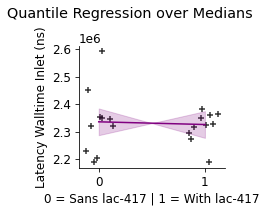

In [85]:
data = df_snapshot_diffs.groupby([
    'Execution Instance UUID',
]).median().reset_index().astype({
    'Num Processes' : 'int64',
    'Allocated Tasks Per Node' : 'int64',
    'Cpus Per Node' : 'int64',
    'Num Simels Per Cpu' : 'int64',
    allocation_idx_mapped_title : 'int64',
})

for viz in facet_unsplit_regression,:
    tp.tee(
        viz,
        data=data,
        row='Num Simels Per Cpu',
        x=allocation_idx_mapped_title,
        y='Latency Walltime Inlet (ns)',
        marker='+',
        x_jitter=0.15,
        regression='Quantile Regression',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs-groupby_exec_instance-median',
            },
            **nbm.collate_outattr_metadata(),
        },
        teeplot_subdir='latency-walltime-inlet-ns',
    )


## Latency Walltime Outlet (ns)


In [86]:
df_snapshot_diffs[
    ~np.isfinite(df_snapshot_diffs['Latency Walltime Outlet (ns)'])
][[
    'Latency Walltime Inlet (ns)',
    'Latency Walltime Outlet (ns)',
    'Snapshot',
    'Runtime Seconds Elapsed Outlet',
    'Hostname',
    'Replicate',
    'Num Simels Per Cpu',
    'Cpus Per Node',
    'Num Processes',
]]


,Latency Walltime Inlet (ns),Latency Walltime Outlet (ns),Snapshot,Runtime Seconds Elapsed Outlet,Hostname,Replicate,Num Simels Per Cpu,Cpus Per Node,Num Processes


teeplots/latency-walltime-outlet-ns/marker=+regression=ordinary-least-squares-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-mean+viz=facet-unsplit-regression+x=0-sans-lac-417-1-with-lac-417+y=latency-w.../alltime-outlet-ns+ext=.pdf
skipping teeplots/latency-walltime-outlet-ns/marker=+regression=ordinary-least-squares-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-mean+viz=facet-unsplit-regression+x=0-sans-lac-417-1-with-lac-417+y=latency-w.../alltime-outlet-ns+ext=.png


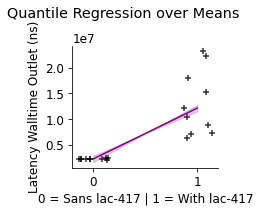

In [87]:
df_snapshot_diffs_copy = df_snapshot_diffs.copy()

# best-case approximation to replace infs/nans
# see listing of infs/nans above
df_snapshot_diffs_copy['Latency Walltime Outlet (ns)'] = (
    df_snapshot_diffs_copy['Outlet-Nanoseconds Elapsed']
    / np.maximum(df_snapshot_diffs_copy['Num Round Trip Touches Outlet'], 1)
)

data = df_snapshot_diffs_copy.groupby([
    'Execution Instance UUID',
]).mean().reset_index().astype({
    'Num Processes' : 'int64',
    'Allocated Tasks Per Node' : 'int64',
    'Cpus Per Node' : 'int64',
    'Num Simels Per Cpu' : 'int64',
    allocation_idx_mapped_title : 'int64',
})

for viz in facet_unsplit_regression,:
    tp.tee(
        viz,
        data=data,
        row='Num Simels Per Cpu',
        x=allocation_idx_mapped_title,
        y='Latency Walltime Outlet (ns)',
        marker='+',
        x_jitter=0.15,
        regression='Ordinary Least Squares Regression',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs-groupby_exec_instance-mean',
            },
            **nbm.collate_outattr_metadata(),
        },
        teeplot_subdir='latency-walltime-outlet-ns',
    )


teeplots/latency-walltime-outlet-ns/marker=+regression=quantile-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-median+viz=facet-unsplit-regression+x=0-sans-lac-417-1-with-lac-417+y=latency-walltime-outl.../et-ns+ext=.pdf
skipping teeplots/latency-walltime-outlet-ns/marker=+regression=quantile-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-median+viz=facet-unsplit-regression+x=0-sans-lac-417-1-with-lac-417+y=latency-walltime-outl.../et-ns+ext=.png


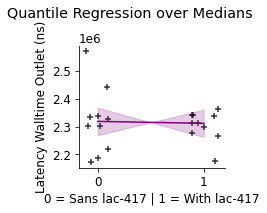

In [88]:
data = df_snapshot_diffs.groupby([
    'Execution Instance UUID',
]).median().reset_index().astype({
    'Num Processes' : 'int64',
    'Allocated Tasks Per Node' : 'int64',
    'Cpus Per Node' : 'int64',
    'Num Simels Per Cpu' : 'int64',
    allocation_idx_mapped_title : 'int64',
})

for viz in facet_unsplit_regression,:
    tp.tee(
        viz,
        data=data,
        row='Num Simels Per Cpu',
        x=allocation_idx_mapped_title,
        y='Latency Walltime Outlet (ns)',
        marker='+',
        x_jitter=0.15,
        regression='Quantile Regression',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs-groupby_exec_instance-median',
            },
            **nbm.collate_outattr_metadata(),
        },
        teeplot_subdir='latency-walltime-outlet-ns',
    )


## Latency Simsteps Inlet


In [89]:
df_snapshot_diffs[
    ~np.isfinite(df_snapshot_diffs['Latency Simsteps Inlet'])
][[
    'Latency Simsteps Inlet',
    'Latency Simsteps Outlet',
    'Snapshot',
    'Runtime Seconds Elapsed Outlet',
    'Hostname',
    'Replicate',
    'Num Simels Per Cpu',
    'Cpus Per Node',
    'Num Processes',
]]


,Latency Simsteps Inlet,Latency Simsteps Outlet,Snapshot,Runtime Seconds Elapsed Outlet,Hostname,Replicate,Num Simels Per Cpu,Cpus Per Node,Num Processes


teeplots/latency-simsteps-inlet/marker=+regression=ordinary-least-squares-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-mean+viz=facet-unsplit-regression+x=0-sans-lac-417-1-with-lac-417+y=latency-s.../imsteps-inlet+ext=.pdf
skipping teeplots/latency-simsteps-inlet/marker=+regression=ordinary-least-squares-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-mean+viz=facet-unsplit-regression+x=0-sans-lac-417-1-with-lac-417+y=latency-s.../imsteps-inlet+ext=.png


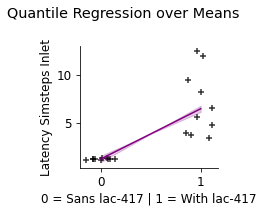

In [90]:
df_snapshot_diffs_copy = df_snapshot_diffs.copy()

# best-case approximation to replace infs/nans
# see listing of infs/nans above
df_snapshot_diffs_copy['Latency Simsteps Inlet'] = (
    df_snapshot_diffs_copy['Num Puts Attempted']
    / np.maximum(df_snapshot_diffs_copy['Num Round Trip Touches Inlet'], 1)
)

data = df_snapshot_diffs_copy.groupby([
    'Execution Instance UUID',
]).mean().reset_index().astype({
    'Num Processes' : 'int64',
    'Allocated Tasks Per Node' : 'int64',
    'Cpus Per Node' : 'int64',
    'Num Simels Per Cpu' : 'int64',
})

for viz in facet_unsplit_regression,:
    tp.tee(
        viz,
        data=data,
        row='Num Simels Per Cpu',
        x=allocation_idx_mapped_title,
        y='Latency Simsteps Inlet',
        marker='+',
        x_jitter=0.15,
        regression='Ordinary Least Squares Regression',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs-groupby_exec_instance-mean',
            },
            **nbm.collate_outattr_metadata(),
        },
        teeplot_subdir='latency-simsteps-inlet',
    )


teeplots/latency-simsteps-inlet/marker=+regression=quantile-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-median+viz=facet-unsplit-regression+x=0-sans-lac-417-1-with-lac-417+y=latency-simsteps-inle.../t+ext=.pdf
skipping teeplots/latency-simsteps-inlet/marker=+regression=quantile-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-median+viz=facet-unsplit-regression+x=0-sans-lac-417-1-with-lac-417+y=latency-simsteps-inle.../t+ext=.png


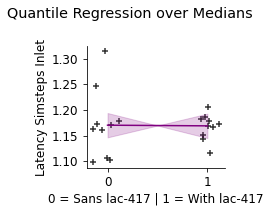

In [91]:
data = df_snapshot_diffs.groupby([
    'Execution Instance UUID',
]).median().reset_index().astype({
    'Num Processes' : 'int64',
    'Allocated Tasks Per Node' : 'int64',
    'Cpus Per Node' : 'int64',
    'Num Simels Per Cpu' : 'int64',
    allocation_idx_mapped_title : 'int64',
})

for viz in facet_unsplit_regression,:
    tp.tee(
        viz,
        data=data,
        row='Num Simels Per Cpu',
        x=allocation_idx_mapped_title,
        y='Latency Simsteps Inlet',
        marker='+',
        x_jitter=0.15,
        regression='Quantile Regression',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs-groupby_exec_instance-median',
            },
            **nbm.collate_outattr_metadata(),
        },
        teeplot_subdir='latency-simsteps-inlet',
    )


## Latency Simsteps Outlet


In [92]:
df_snapshot_diffs[
    ~np.isfinite(df_snapshot_diffs['Latency Simsteps Outlet'])
][[
    'Latency Simsteps Inlet',
    'Latency Simsteps Outlet',
    'Snapshot',
    'Runtime Seconds Elapsed Outlet',
    'Hostname',
    'Replicate',
    'Num Simels Per Cpu',
    'Cpus Per Node',
    'Num Processes',
]]


,Latency Simsteps Inlet,Latency Simsteps Outlet,Snapshot,Runtime Seconds Elapsed Outlet,Hostname,Replicate,Num Simels Per Cpu,Cpus Per Node,Num Processes


teeplots/latency-simsteps-outlet/marker=+regression=ordinary-least-squares-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-mean+viz=facet-unsplit-regression+x=0-sans-lac-417-1-with-lac-417+y=latency-s.../imsteps-outlet+ext=.pdf
skipping teeplots/latency-simsteps-outlet/marker=+regression=ordinary-least-squares-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-mean+viz=facet-unsplit-regression+x=0-sans-lac-417-1-with-lac-417+y=latency-s.../imsteps-outlet+ext=.png


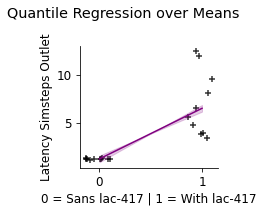

In [93]:
df_snapshot_diffs_copy = df_snapshot_diffs.copy()

# best-case approximation to replace infs/nans
# see listing of infs/nans above
df_snapshot_diffs_copy['Latency Simsteps Outlet'] = (
    df_snapshot_diffs_copy['Num Pulls Attempted']
    / np.maximum(df_snapshot_diffs_copy['Num Round Trip Touches Outlet'], 1)
)

data = df_snapshot_diffs_copy.groupby([
    'Execution Instance UUID',
]).mean().reset_index().astype({
    'Num Processes' : 'int64',
    'Allocated Tasks Per Node' : 'int64',
    'Cpus Per Node' : 'int64',
    'Num Simels Per Cpu' : 'int64',
    allocation_idx_mapped_title : 'int64',
})

for viz in facet_unsplit_regression,:
    tp.tee(
        viz,
        data=data,
        row='Num Simels Per Cpu',
        x=allocation_idx_mapped_title,
        y='Latency Simsteps Outlet',
        marker='+',
        x_jitter=0.15,
        regression='Ordinary Least Squares Regression',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs-groupby_exec_instance-mean',
            },
            **nbm.collate_outattr_metadata(),
        },
        teeplot_subdir='latency-simsteps-outlet',
    )


teeplots/latency-simsteps-outlet/marker=+regression=quantile-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-median+viz=facet-unsplit-regression+x=0-sans-lac-417-1-with-lac-417+y=latency-simsteps-outl.../et+ext=.pdf
skipping teeplots/latency-simsteps-outlet/marker=+regression=quantile-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-median+viz=facet-unsplit-regression+x=0-sans-lac-417-1-with-lac-417+y=latency-simsteps-outl.../et+ext=.png


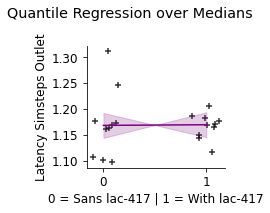

In [94]:
data = df_snapshot_diffs.groupby([
    'Execution Instance UUID',
]).median().reset_index().astype({
    'Num Processes' : 'int64',
    'Allocated Tasks Per Node' : 'int64',
    'Cpus Per Node' : 'int64',
    'Num Simels Per Cpu' : 'int64',
    allocation_idx_mapped_title : 'int64',
})

for viz in facet_unsplit_regression,:
    tp.tee(
        viz,
        data=data,
        row='Num Simels Per Cpu',
        x=allocation_idx_mapped_title,
        y='Latency Simsteps Outlet',
        marker='+',
        x_jitter=0.15,
        regression='Quantile Regression',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs-groupby_exec_instance-median',
            },
            **nbm.collate_outattr_metadata(),
        },
        teeplot_subdir='latency-simsteps-outlet',
    )


## Delivery Failure Rate


In [95]:
df_snapshot_diffs[
    ~np.isfinite(df_snapshot_diffs['Delivery Failure Rate'])
][[
    'Delivery Failure Rate',
    'Snapshot',
    'Runtime Seconds Elapsed Outlet',
    'Hostname',
    'Replicate',
    'Num Simels Per Cpu',
    'Cpus Per Node',
    'Num Processes',
]]


,Delivery Failure Rate,Snapshot,Runtime Seconds Elapsed Outlet,Hostname,Replicate,Num Simels Per Cpu,Cpus Per Node,Num Processes


teeplots/delivery-failure-rate/marker=+regression=ordinary-least-squares-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-mean+viz=facet-unsplit-regression+x=0-sans-lac-417-1-with-lac-417+y=delivery-.../failure-rate+ext=.pdf
skipping teeplots/delivery-failure-rate/marker=+regression=ordinary-least-squares-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-mean+viz=facet-unsplit-regression+x=0-sans-lac-417-1-with-lac-417+y=delivery-.../failure-rate+ext=.png


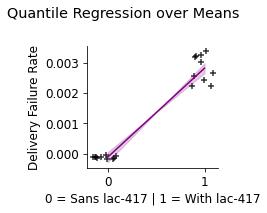

In [96]:
data = df_snapshot_diffs.groupby([
    'Execution Instance UUID',
]).mean().reset_index().astype({
    'Num Processes' : 'int64',
    'Allocated Tasks Per Node' : 'int64',
    'Cpus Per Node' : 'int64',
    'Num Simels Per Cpu' : 'int64',
    allocation_idx_mapped_title : 'int64',
})

for viz in facet_unsplit_regression,:
    tp.tee(
        viz,
        data=data,
        row='Num Simels Per Cpu',
        x=allocation_idx_mapped_title,
        y='Delivery Failure Rate',
        marker='+',
        x_jitter=0.15,
        regression='Ordinary Least Squares Regression',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs-groupby_exec_instance-mean',
            },
            **nbm.collate_outattr_metadata(),
        },
        teeplot_subdir='delivery-failure-rate',
    )


teeplots/delivery-failure-rate/marker=+regression=quantile-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-median+viz=facet-unsplit-regression+x=0-sans-lac-417-1-with-lac-417+y=delivery-failure-rate.../+ext=.pdf
skipping teeplots/delivery-failure-rate/marker=+regression=quantile-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-median+viz=facet-unsplit-regression+x=0-sans-lac-417-1-with-lac-417+y=delivery-failure-rate.../+ext=.png


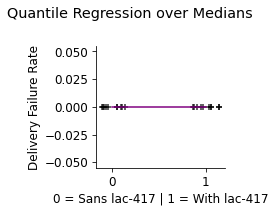

In [97]:
data = df_snapshot_diffs.groupby([
    'Execution Instance UUID',
]).median().reset_index().astype({
    'Num Processes' : 'int64',
    'Allocated Tasks Per Node' : 'int64',
    'Cpus Per Node' : 'int64',
    'Num Simels Per Cpu' : 'int64',
    allocation_idx_mapped_title : 'int64',
})

for viz in facet_unsplit_regression,:
    tp.tee(
        viz,
        data=data,
        row='Num Simels Per Cpu',
        x=allocation_idx_mapped_title,
        y='Delivery Failure Rate',
        marker='+',
        x_jitter=0.15,
        regression='Quantile Regression',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs-groupby_exec_instance-median',
            },
            **nbm.collate_outattr_metadata(),
        },
        teeplot_subdir='delivery-failure-rate',
    )


## Delivery Clumpiness


In [98]:
df_snapshot_diffs[
    ~np.isfinite(df_snapshot_diffs['Delivery Clumpiness'])
][[
    'Delivery Clumpiness',
    'Snapshot',
    'Runtime Seconds Elapsed Outlet',
    'Hostname',
    'Replicate',
    'Num Simels Per Cpu',
    'Cpus Per Node',
    'Num Processes',
]]


,Delivery Clumpiness,Snapshot,Runtime Seconds Elapsed Outlet,Hostname,Replicate,Num Simels Per Cpu,Cpus Per Node,Num Processes


teeplots/delivery-clumpiness/marker=+regression=ordinary-least-squares-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-mean+viz=facet-unsplit-regression+x=0-sans-lac-417-1-with-lac-417+y=delivery-.../clumpiness+ext=.pdf
skipping teeplots/delivery-clumpiness/marker=+regression=ordinary-least-squares-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-mean+viz=facet-unsplit-regression+x=0-sans-lac-417-1-with-lac-417+y=delivery-.../clumpiness+ext=.png


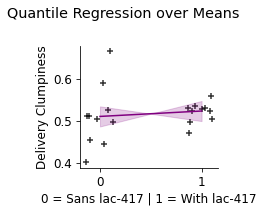

In [99]:
data = df_snapshot_diffs.groupby([
    'Execution Instance UUID',
]).mean().reset_index().astype({
    'Num Processes' : 'int64',
    'Allocated Tasks Per Node' : 'int64',
    'Cpus Per Node' : 'int64',
    'Num Simels Per Cpu' : 'int64',
    allocation_idx_mapped_title : 'int64',
})

for viz in facet_unsplit_regression,:
    tp.tee(
        viz,
        data=data,
        row='Num Simels Per Cpu',
        x=allocation_idx_mapped_title,
        y='Delivery Clumpiness',
        marker='+',
        x_jitter=0.15,
        regression='Ordinary Least Squares Regression',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs-groupby_exec_instance-mean',
            },
            **nbm.collate_outattr_metadata(),
        },
        teeplot_subdir='delivery-clumpiness',
    )


teeplots/delivery-clumpiness/marker=+regression=quantile-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-median+viz=facet-unsplit-regression+x=0-sans-lac-417-1-with-lac-417+y=delivery-clumpiness+e.../xt=.pdf
skipping teeplots/delivery-clumpiness/marker=+regression=quantile-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-median+viz=facet-unsplit-regression+x=0-sans-lac-417-1-with-lac-417+y=delivery-clumpiness+e.../xt=.png


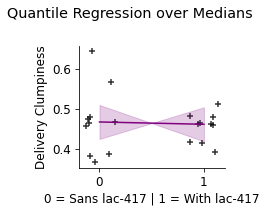

In [100]:
data = df_snapshot_diffs.groupby([
    'Execution Instance UUID',
]).median().reset_index().astype({
    'Num Processes' : 'int64',
    'Allocated Tasks Per Node' : 'int64',
    'Cpus Per Node' : 'int64',
    'Num Simels Per Cpu' : 'int64',
    allocation_idx_mapped_title : 'int64',
})


for viz in facet_unsplit_regression,:
    tp.tee(
        viz,
        data=data,
        row='Num Simels Per Cpu',
        x=allocation_idx_mapped_title,
        y='Delivery Clumpiness',
        marker='+',
        x_jitter=0.15,
        regression='Quantile Regression',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs-groupby_exec_instance-median',
            },
            **nbm.collate_outattr_metadata(),
        },
        teeplot_subdir='delivery-clumpiness',
    )


## Simstep Period Inlet (ns)


In [101]:
df_snapshot_diffs[
    ~np.isfinite(df_snapshot_diffs['Simstep Period Inlet (ns)'])
][[
    'Simstep Period Inlet (ns)',
    'Simstep Period Outlet (ns)',
    'Snapshot',
    'Runtime Seconds Elapsed Outlet',
    'Hostname',
    'Replicate',
    'Num Simels Per Cpu',
    'Cpus Per Node',
    'Num Processes',
]]


,Simstep Period Inlet (ns),Simstep Period Outlet (ns),Snapshot,Runtime Seconds Elapsed Outlet,Hostname,Replicate,Num Simels Per Cpu,Cpus Per Node,Num Processes


teeplots/simstep-period-inlet-ns/marker=+regression=ordinary-least-squares-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-mean+viz=facet-unsplit-regression+x=0-sans-lac-417-1-with-lac-417+y=simstep-p.../eriod-inlet-ns+ext=.pdf
skipping teeplots/simstep-period-inlet-ns/marker=+regression=ordinary-least-squares-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-mean+viz=facet-unsplit-regression+x=0-sans-lac-417-1-with-lac-417+y=simstep-p.../eriod-inlet-ns+ext=.png


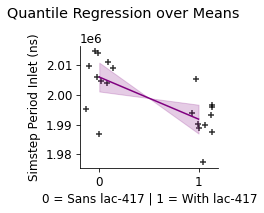

In [102]:
df_snapshot_diffs_copy = df_snapshot_diffs.copy()

# best-case approximation to replace infs
# see listing of infs above
df_snapshot_diffs_copy['Simstep Period Inlet (ns)'] = (
    df_snapshot_diffs_copy['Inlet-Nanoseconds Elapsed']
    / np.maximum(df_snapshot_diffs_copy['Num Puts Attempted'], 1)
)

data = df_snapshot_diffs_copy.groupby([
    'Execution Instance UUID',
]).mean().reset_index().astype({
    'Num Processes' : 'int64',
    'Allocated Tasks Per Node' : 'int64',
    'Cpus Per Node' : 'int64',
    'Num Simels Per Cpu' : 'int64',
    allocation_idx_mapped_title : 'int64',
})

for viz in facet_unsplit_regression,:
    tp.tee(
        viz,
        data=data,
        row='Num Simels Per Cpu',
        x=allocation_idx_mapped_title,
        y='Simstep Period Inlet (ns)',
        marker='+',
        x_jitter=0.15,
        regression='Ordinary Least Squares Regression',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs-groupby_exec_instance-mean',
            },
            **nbm.collate_outattr_metadata(),
        },
        teeplot_subdir='simstep-period-inlet-ns',
    )


teeplots/simstep-period-inlet-ns/marker=+regression=quantile-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-median+viz=facet-unsplit-regression+x=0-sans-lac-417-1-with-lac-417+y=simstep-period-inlet-.../ns+ext=.pdf
skipping teeplots/simstep-period-inlet-ns/marker=+regression=quantile-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-median+viz=facet-unsplit-regression+x=0-sans-lac-417-1-with-lac-417+y=simstep-period-inlet-.../ns+ext=.png


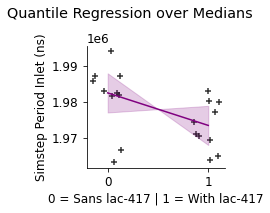

In [103]:
data = df_snapshot_diffs.groupby([
    'Execution Instance UUID',
]).median().reset_index().astype({
    'Num Processes' : 'int64',
    'Allocated Tasks Per Node' : 'int64',
    'Cpus Per Node' : 'int64',
    'Num Simels Per Cpu' : 'int64',
    allocation_idx_mapped_title : 'int64',
})

for viz in facet_unsplit_regression,:
    tp.tee(
        viz,
        data=data,
        row='Num Simels Per Cpu',
        x=allocation_idx_mapped_title,
        y='Simstep Period Inlet (ns)',
        marker='+',
        x_jitter=0.15,
        regression='Quantile Regression',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs-groupby_exec_instance-median',
            },
            **nbm.collate_outattr_metadata(),
        },
        teeplot_subdir='simstep-period-inlet-ns',
    )


## Simstep Period Outlet (ns)


In [104]:
df_snapshot_diffs[
    ~np.isfinite(df_snapshot_diffs['Simstep Period Outlet (ns)'])
][[
    'Simstep Period Inlet (ns)',
    'Simstep Period Outlet (ns)',
    'Snapshot',
    'Runtime Seconds Elapsed Outlet',
    'Hostname',
    'Replicate',
    'Num Simels Per Cpu',
    'Cpus Per Node',
    'Num Processes',
]]


,Simstep Period Inlet (ns),Simstep Period Outlet (ns),Snapshot,Runtime Seconds Elapsed Outlet,Hostname,Replicate,Num Simels Per Cpu,Cpus Per Node,Num Processes


teeplots/simstep-period-outlet-ns/marker=+regression=ordinary-least-squares-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-mean+viz=facet-unsplit-regression+x=0-sans-lac-417-1-with-lac-417+y=simstep-p.../eriod-outlet-ns+ext=.pdf
skipping teeplots/simstep-period-outlet-ns/marker=+regression=ordinary-least-squares-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-mean+viz=facet-unsplit-regression+x=0-sans-lac-417-1-with-lac-417+y=simstep-p.../eriod-outlet-ns+ext=.png


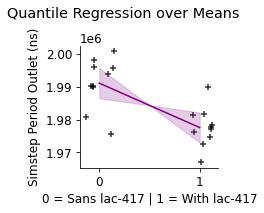

In [105]:
df_snapshot_diffs_copy = df_snapshot_diffs.copy()

# best-case approximation to replace infs
# see listing of infs above
df_snapshot_diffs_copy['Simstep Period Outlet (ns)'] = (
    df_snapshot_diffs_copy['Outlet-Nanoseconds Elapsed']
    / np.maximum(df_snapshot_diffs_copy['Num Pulls Attempted'], 1)
)

data = df_snapshot_diffs_copy.groupby([
    'Execution Instance UUID',
]).mean().reset_index().astype({
    'Num Processes' : 'int64',
    'Allocated Tasks Per Node' : 'int64',
    'Cpus Per Node' : 'int64',
    'Num Simels Per Cpu' : 'int64',
    allocation_idx_mapped_title : 'int64',
})

for viz in facet_unsplit_regression,:
    tp.tee(
        viz,
        data=data,
        row='Num Simels Per Cpu',
        x=allocation_idx_mapped_title,
        y='Simstep Period Outlet (ns)',
        marker='+',
        x_jitter=0.15,
        regression='Ordinary Least Squares Regression',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs-groupby_exec_instance-mean',
            },
            **nbm.collate_outattr_metadata(),
        },
        teeplot_subdir='simstep-period-outlet-ns',
    )


teeplots/simstep-period-outlet-ns/marker=+regression=quantile-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-median+viz=facet-unsplit-regression+x=0-sans-lac-417-1-with-lac-417+y=simstep-period-outlet.../-ns+ext=.pdf
skipping teeplots/simstep-period-outlet-ns/marker=+regression=quantile-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-median+viz=facet-unsplit-regression+x=0-sans-lac-417-1-with-lac-417+y=simstep-period-outlet.../-ns+ext=.png


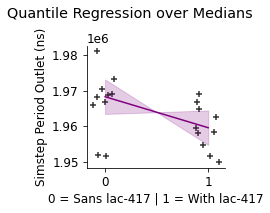

In [106]:
data = df_snapshot_diffs.groupby([
    'Execution Instance UUID',
]).median().reset_index().astype({
    'Num Processes' : 'int64',
    'Allocated Tasks Per Node' : 'int64',
    'Cpus Per Node' : 'int64',
    'Num Simels Per Cpu' : 'int64',
    allocation_idx_mapped_title : 'int64',
})

for viz in facet_unsplit_regression,:
    tp.tee(
        viz,
        data=data,
        row='Num Simels Per Cpu',
        x=allocation_idx_mapped_title,
        y='Simstep Period Outlet (ns)',
        marker='+',
        x_jitter=0.15,
        regression='Quantile Regression',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs-groupby_exec_instance-median',
            },
            **nbm.collate_outattr_metadata(),
        },
        teeplot_subdir='simstep-period-outlet-ns',
    )


# Outlier Analysis


In [107]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
df_snapshot_diffs[
    (df_snapshot_diffs['Latency Simsteps Inlet'] > 50)
    & (df_snapshot_diffs['Num Simels Per Cpu'] == 1)
]


,Process Instance UUID,Snapshot,Async Mode,Num Nodes,Allocated Tasks Per Node,Cpus Per Node,Num Processes,Log Num Processes,Num Simels Per Cpu,Replicate,proc,Hostname,Num Inlets,Num Outlets,Execution Instance UUID,Num Threads,Allocation,Has Execution Blur,Num Puts Attempted,Num Try Puts Attempted,Num Blocking Puts,Num Try Puts That Succeeded,Num Puts That Succeeded Eventually,Num Blocking Puts That Succeeded Immediately,Num Puts That Succeeded Immediately,Num Puts That Blocked,Num Dropped Puts,Num Reads Performed,Num Reads That Were Fresh,Num Reads That Were Stale,Num Revisions Pulled,Num Try Pulls Attempted,Num Blocking Pulls,Num Blocking Pulls That Blocked,Num Revisions From Try Pulls,Num Revisions From Blocking Pulls,Num Pulls Attempted,Num Pulls That Were Laden Eventually,Num Blocking Pulls That Were Laden Immediately,Num Blocking Pulls That Were Laden Eventually,Num Pulls That Were Laden Immediately,Num Try Pulls That Were Laden,Num Try Pulls That Were Unladen,Net Flux Through Duct,Num Round Trip Touches Inlet,Num Round Trip Touches Outlet,Row Final Timepoint (ns) Inlet,Row Final Timepoint (ns) Outlet,Runtime Seconds Elapsed Inlet,Runtime Seconds Elapsed Outlet,Fraction Messages Delivered,Delivery Success Rate,Delivery Failure Rate,Fraction Messages Dropped,Fraction Try Pulls That Were Laden,Round Trip Touches Per Attempted Put,Round Trip Touches Per Attempted Pull,Round Trip Touches Per Runtime Nanosecond,Latency Simsteps Inlet,Latency Simsteps Outlet,Inlet-Nanoseconds Elapsed,Outlet-Nanoseconds Elapsed,Simsteps Elapsed Inlet,Simsteps Elapsed Outlet,Simstep Period Inlet (ns),Simstep Period Outlet (ns),Latency Walltime Inlet (ns),Latency Walltime Outlet (ns),Dominance,Num Messages Per Pull,Num Messages Per Laden Pull,Bunchiness,Delivery Clumpiness,Intermittancy,Bunching,"Latency, Log10 Updates",ms Per Update,"Delivery Failure, %",% Msgs Lost,Msgs Received Per Sent,Messages Received Per Second,Messages Sent Per Second,Any Messages Dropped,0 = Sans lac-417 | 1 = With lac-417


In [108]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
df_snapshot_diffs[
    (df_snapshot_diffs['Latency Simsteps Inlet'] > 50)
    & (df_snapshot_diffs['Num Simels Per Cpu'] == 2048)
]


,Process Instance UUID,Snapshot,Async Mode,Num Nodes,Allocated Tasks Per Node,Cpus Per Node,Num Processes,Log Num Processes,Num Simels Per Cpu,Replicate,proc,Hostname,Num Inlets,Num Outlets,Execution Instance UUID,Num Threads,Allocation,Has Execution Blur,Num Puts Attempted,Num Try Puts Attempted,Num Blocking Puts,Num Try Puts That Succeeded,Num Puts That Succeeded Eventually,Num Blocking Puts That Succeeded Immediately,Num Puts That Succeeded Immediately,Num Puts That Blocked,Num Dropped Puts,Num Reads Performed,Num Reads That Were Fresh,Num Reads That Were Stale,Num Revisions Pulled,Num Try Pulls Attempted,Num Blocking Pulls,Num Blocking Pulls That Blocked,Num Revisions From Try Pulls,Num Revisions From Blocking Pulls,Num Pulls Attempted,Num Pulls That Were Laden Eventually,Num Blocking Pulls That Were Laden Immediately,Num Blocking Pulls That Were Laden Eventually,Num Pulls That Were Laden Immediately,Num Try Pulls That Were Laden,Num Try Pulls That Were Unladen,Net Flux Through Duct,Num Round Trip Touches Inlet,Num Round Trip Touches Outlet,Row Final Timepoint (ns) Inlet,Row Final Timepoint (ns) Outlet,Runtime Seconds Elapsed Inlet,Runtime Seconds Elapsed Outlet,Fraction Messages Delivered,Delivery Success Rate,Delivery Failure Rate,Fraction Messages Dropped,Fraction Try Pulls That Were Laden,Round Trip Touches Per Attempted Put,Round Trip Touches Per Attempted Pull,Round Trip Touches Per Runtime Nanosecond,Latency Simsteps Inlet,Latency Simsteps Outlet,Inlet-Nanoseconds Elapsed,Outlet-Nanoseconds Elapsed,Simsteps Elapsed Inlet,Simsteps Elapsed Outlet,Simstep Period Inlet (ns),Simstep Period Outlet (ns),Latency Walltime Inlet (ns),Latency Walltime Outlet (ns),Dominance,Num Messages Per Pull,Num Messages Per Laden Pull,Bunchiness,Delivery Clumpiness,Intermittancy,Bunching,"Latency, Log10 Updates",ms Per Update,"Delivery Failure, %",% Msgs Lost,Msgs Received Per Sent,Messages Received Per Second,Messages Sent Per Second,Any Messages Dropped,0 = Sans lac-417 | 1 = With lac-417
2478,1347abb5-dc75-4256-b6e7-4743b0b82952,0,3,256,1,1,256,4.0,2048,8,242,lac-417,186,186,d92d03ed-a353-41f4-8baa-a3024a53fc91,1,With lac-417,2,99911,99911,0,61538,99911,0,61538,0,38373,306459,18844,287615,18844,102296,0,0,18844,0,102296,18844,0,0,18844,18844,83452,67061,55,55,1016442880,1028104285,12.5,12.5,0.615928,0.615928,0.384072,0.384072,0.184211,0.000550,0.000538,5.349652e-08,1816.563636,1859.927273,189058375680,191227397010,537.155914,549.978495,1.892268e+06,1.869354e+06,3.437425e+09,3.476862e+09,1.489853,0.655558,3.558745,4.428571,4.428571,4.428571,4.428571,3.259251,1.892268,38.407182,38.407182,0.655558,350.687198,528.466404,True,1
2479,1347abb5-dc75-4256-b6e7-4743b0b82952,1,3,256,1,1,256,4.0,2048,8,242,lac-417,186,186,d92d03ed-a353-41f4-8baa-a3024a53fc91,1,With lac-417,2,101382,101382,0,53997,101382,0,53997,0,47385,302665,17605,285060,17605,100976,0,0,17605,0,100976,17605,0,0,17605,17605,83371,64965,84,84,1016310710,1014183844,72.5,73.0,0.532609,0.532609,0.467391,0.467391,0.174348,0.000829,0.000832,8.282522e-08,1206.928571,1202.095238,189033792060,188638194984,545.064516,542.881720,1.864570e+06,1.868149e+06,2.250402e+09,2.245693e+09,1.560563,0.643371,3.690145,4.735643,4.735643,4.735643,4.735643,3.081682,1.864570,46.739066,46.739066,0.643371,344.389428,536.316808,True,1
2480,1347abb5-dc75-4256-b6e7-4743b0b82952,2,3,256,1,1,256,4.0,2048,8,242,lac-417,186,186,d92d03ed-a353-41f4-8baa-a3024a53fc91,1,With lac-417,2,101885,101885,0,47136,101885,0,47136,0,54749,304149,15075,289074,15075,101383,0,0,15075,0,101383,15075,0,0,15075,15075,86308,64845,330,330,1016286782,1014036368,132.5,133.0,0.462639,0.462639,0.537361,0.537361,0.148694,0.003239,0.003255,3.254321e-07,308.742424,307.221212,189029341452,188610764448,547.768817,545.069892,1.855321e+06,1.860379e+06,5.728162e+08,5.715478e+08,1.571208,0.639604,4.301493,5.725240,5.725240,5.725240,5.725240,2.489596,1.855321,53.736075,53.736075,0.639604,343.803283,538.990398,True,1
2481,1347abb5-dc75-4256-b6e7-4743b0